<a href="https://colab.research.google.com/github/romanAVJ/Optimal_Bets_PremierLeague/blob/master/Financial_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Models
**Román Alberto Vélez Jiménez**, roman.velez.jimenez@gmail.com

- Notebook to get into the _Kelly Criterion_ and _Markowitz Portfolio Optimization_. The core of the present script is to generate some betting strategies for the English Premier League following this criteria.

- This script is made for a mathematics bachelor's thesis

- The probabilities for the English Premier League used here were previously estimated with neural networks in other Colab.



# Functions, Libraries and Updates

In this chunks we clone Roman's thesis repository to obtain the databases. As well, install, update and import necessary libraries.

## Get .py files and data from GitHub Repo

Clone the entire repo to a local file.

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/romanAVJ/Optimal_Bets_PremierLeague.git cloned-repo

# move to folder "cloned repo"
%cd cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 1798, done.
remote: Counting objects: 100% (1798/1798), done.
remote: Compressing objects: 100% (978/978), done.
remote: Total 1798 (delta 573), reused 1787 (delta 565), pack-reused 0
Receiving objects: 100% (1798/1798), 28.33 MiB | 23.32 MiB/s, done.
Resolving deltas: 100% (573/573), done.
/content/cloned-repo


## Install, Update & Import libraries 

In [ ]:
# install libraries
!pip install adjustText
%pip install scipy==1.7.0

# import 
import os 
import pandas as pd
import numpy as np
import warnings
import scipy
import scipy.optimize as optimize
import scipy.stats as sstats
from scipy.sparse import csc_matrix
from scipy import linalg
from itertools import product

import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=e2a7169f985ffbf07bfcb206aa0a8fab98ee8b7da204c54bd0d0253ffec73808
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
     |████████████████████████████████| 28.5 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Own functions 

Generate own functions to make easier and more neat the script.

In [ ]:
# library
# general portfolio
def get_meanvar_params(games):
    # portfolio expectation - no risk free asset
    mu = bets_mean(probas=games['probas'], odds=games['odds'])
    
    # variance-covariance matrix
    SIGMAm = covariance_games(games)
    
    # dict out
    dict_main = {
        'mu': mu,
        'SIGMAm': SIGMAm        
    }
    
    return(dict_main)

def get_loggrowth_params(games, is_bivariate=False, tol=1e-6):
    # unpack values
    m = games['num_events']
    r = games['num_games']
    
    # posibility matrix
    OMEGAm = posibility_matrix(m=m, n=r, is_bivariate=is_bivariate)
    
    # generate values of dictionary
    dict_main = {
        # trasnposed win matrix
        'Wt': np.matmul(np.transpose(OMEGAm), np.diag(games['odds'])),        
        # probabilities
        'proba_posibilities': independent_probabilities(
            Mposibilities=OMEGAm, 
            probas=games['probas'],
            is_bivariate=is_bivariate,
            tol=tol
        )        
    }    
    
    return(dict_main)

def get_portfolio_params(games, tol=1e-6):
    # look if is bivariate
    # look if is bivariate or multivariate
    if games['num_events'] > 1:
        is_bivariate=False
    else:
        is_bivariate=True
    
    # get params
    # kelly params
    dict_out = get_meanvar_params(games) 
    # markowitz params
    dict_out.update(get_loggrowth_params(games, is_bivariate=is_bivariate, tol=tol))  

    return(dict_out)

# kelly optimization
def posibility_matrix(m, n, is_bivariate=False):    
    # idea asked by autor in 
    # https://stackoverflow.com/questions/69531178/create-an-sparse-matrix-from-a-list-of-tuples-having-the-indexes-of-the-column-w
    if not is_bivariate:
        # generate all inedx posible combinations
        posibilities = list(product(range(m), repeat=n)) 
        matrix_index_indicator = np.array(posibilities, dtype=np.int32)
        
        # get indexes for sparse matrix
        # add m for each index to section the flatten matrix index
        narray_indexer = np.cumsum(np.repeat(m, n)) - m
        matrix_index = matrix_index_indicator + narray_indexer
        
        # generate indexes and indptr for sparse matrix
        indices_event = matrix_index.flatten(order='C') # append rows
        
        aux_indptr = np.concatenate((np.array([0]), np.repeat(n, len(posibilities))))
        indptr = np.cumsum(aux_indptr) # sectionate the indices
    
        # generate sparse matrix of posibilities and cast to numpy
        array1d_sparse = np.ones(indptr[-1], dtype=int)
        A = csc_matrix((array1d_sparse, indices_event, indptr)).toarray()
        
    else:
        # generate all binomial posible combinations
        posibilities = list(product(range(2), repeat=n)) 
        
        # get posiblility matrix
        A = np.transpose(np.array(posibilities, dtype=np.int32))  
   
    return(A)

def set_probas(omega, probas):
    # compare if an ouctome happened or not and return probability
    p = np.where(omega > 0, probas, 1 - probas) 
    
    return(p) 

def independent_probabilities(Mposibilities, probas, is_bivariate=False, tol=1e-6):
    # get probaility matrix
    if not is_bivariate:
        # get probability matrix with 0's
        Pm = np.matmul(np.diag(probas), Mposibilities)
    
        # get proba matrix
        Pm[Pm == 0] = 1      
    else:
        # get probabilities for each element in omega
        Pm = np.apply_along_axis(
            func1d=set_probas,
            axis=0,                 # by row
            arr=Mposibilities,
            probas=probas           # *args
        )
    
    # get each posible combination probability
    proba_posibilities = np.prod(Pm, axis=0) # multiply rows 
        
    # look that the sum is closely to 1
    sum_probas = np.sum(proba_posibilities)
    if np.abs(sum_probas - 1) >  tol:
        warnings.warn(
            f"""The sum of proabilities was {sum_probas} 
            and is out of +/-{tol} tolaration"""
            )   
    
    return(proba_posibilities)

def log_growth(bets, Wt, probs):   
    # get expected log return
    Gl = np.dot(probs, np.log(1 + np.matmul(Wt, bets) - np.sum(bets)))
    
    return(Gl)

def log_growth_grad(bets, Wt, probs): 
    # numerator
    xwin_return = Wt - 1
    xreturn = 1 + np.matmul(Wt, bets) - np.sum(bets)
    
    # divide each row by xreturn
    xwin_return_gradient = np.divide(xwin_return, xreturn[:, np.newaxis]) 
    
    # gradient
    Gl_grad = np.dot(np.transpose(xwin_return_gradient), probs)

    return(Gl_grad)

# aux functions for kelly stake
def neg_log_growth(bets, Wt, probs):
    return(- log_growth(bets, Wt, probs))

def neg_log_growth_grad(bets, Wt, probs):
    return(- log_growth_grad(bets, Wt, probs))

def restrictions_bounds_kelly(m_all, fractional=1):
    # constraint
    ineq_cons_budget = {
        'type': 'ineq',
        'fun': lambda x: fractional - np.sum(x),
        'jac': lambda x: - np.ones(x.shape)
    }
    
    constraints = (ineq_cons_budget,)
    
    # bounds
    lb = np.zeros(m_all)
    ub = np.repeat(fractional, m_all)
    bounds = optimize.Bounds(lb, ub)
    
    return(constraints, bounds)   

def get_initial_params_kelly(games, fractional=1, is_bivariate=False):
    # unpack values
    m = games['num_events']
    r = games['num_games']
    
    if not is_bivariate:
        m_all = m * r
    else:
        m_all = r      
        
    # restrictions
    constraints, bounds = restrictions_bounds_kelly(m_all, fractional=fractional)
    
    # initial feasble point
    x0 = np.zeros(m_all)
    
    # dict out
    dict_out = {
        'constraints': constraints,
        'bounds': bounds,
        'x0': x0   
    }  
    
    return(dict_out)

def kelly_stake(games, params, fractional=1, xmin=1e-4, ftol=1e-12):
    # look if is bivariate or multivariate
    if games['num_events'] > 1:
        is_bivariate=False
    else:
        is_bivariate=True
    
    #  maximize(f) <-> - minimize(-f)
    # initial values
    init_values = get_initial_params_kelly(
        games=games, 
        is_bivariate=is_bivariate, 
        fractional=fractional
    )
    
    # quadratic programming optimization (convex function)
    WTm = params['Wt'].copy()
    probas = params['proba_posibilities'].copy()
    
    opt = optimize.minimize(
        fun=neg_log_growth,             # maximize the negative log growth
        x0=init_values['x0'],           # initial point
        args=(WTm, probas),             # arguments for the function and the gradient
        method='SLSQP',                  
        jac=neg_log_growth_grad,        # gradient
        bounds=init_values['bounds'],
        constraints=init_values['constraints'],
        options={'ftol': ftol, 'disp': False}    
    )    
    
    if not opt['success']:
        warnings.warn(f"Optimization for Kelly wasn't succesful")     
    
    # tidy results
    dict_result = {
        'fmax': - opt['fun'],
        'x_opt': np.where(opt['x'] >= xmin, opt['x'], 0)        
    }
    
    return(dict_result)

# markowitz optimization
def portfolio_returns(bets, returns):   
    # estimate mean
    portfolio_return = np.dot(bets, returns)
    
    return(portfolio_return)

def portfolio_volatility(bets, sigma):     
    # get volatitilty defined as total variance
    vol = np.dot(bets, np.matmul(sigma, bets)) # x'S x

    return(vol)

def portfolio_volatility_jac(bets, sigma):
    gradient = 2 * np.matmul(sigma, bets)
    return(gradient)

def sharpe_ratio(bets, returns, sigma):
    sharpe = portfolio_returns(bets, returns) / np.sqrt(portfolio_volatility(bets, sigma))
    return(sharpe)

def bets_mean(probas, odds):
    rho = odds * probas - 1 # decimal odds    
    return(rho)

def exclusive_bets_covariance(odds, probas):
    # get var-covar matrix of a multinomial distribution
    # i.e. Var(M) =  diag(p) - p p.T (outer product)
    sigma_multinomial = np.diag(probas) - np.outer(probas, probas)
    
    # Var(DM - 1) = D Var(M) D.T
    diag_odds = np.diag(odds)
    sigma_exclusive_bets = np.matmul(
        np.matmul(diag_odds, sigma_multinomial), diag_odds
    )        
    
    return(sigma_exclusive_bets)

def covariance_games(games):   
    # split games
    # get index to split array for all possible outcomes in a game
    games_index_split = np.cumsum(pd.Series(games['id_game']).value_counts().to_numpy())[:-1]    
    # get list of odds & probas per game
    games_odds = np.array_split(games['odds'], games_index_split)
    games_probas = np.array_split(games['probas'], games_index_split)    
    
    # get var covar matrix per game
    list_sigmas = [
        exclusive_bets_covariance(o, p) for o, p in zip(games_odds, games_probas)
    ]  
    
    # variance covariance for all games
    VAR_COVARm = linalg.block_diag(*list_sigmas)
    
    return(VAR_COVARm)

def restrictions_bounds_markowitz(mu):
    m_all = len(mu)
    # note: (y, kappa) <-> (x[:-1], x[-1])
    # constraints
    # 1. sum(y) = kappa    
    eq_cons_kappa = {
        'type': 'eq',
        'fun': lambda y: np.sum(y[:-1]) - y[-1],
        'jac': lambda y: np.concatenate((np.ones(m_all), np.array([-1])))
    }
    # 2. y'mu = 1
    eq_cons_budget = {
        'type': 'eq',
        'fun': lambda y: np.dot(y[:-1], mu) - 1,
        'jac': lambda y: np.concatenate((mu, np.array([0])))
    }
    constraints = (eq_cons_kappa, eq_cons_budget)
    
    # bounds
    lb = np.zeros(m_all + 1) # +1 for kappa
    ub = np.repeat(np.Inf, m_all + 1) # unbounded kappa values
    bounds = optimize.Bounds(lb, ub)        
    
    return(constraints, bounds)

def initial_point_markowitz(mu):
    # get inverse of the mean
    inverse_mu = 1/mu
    
    # index with maximum value
    imax = inverse_mu.argmax()
    
    # generate initial feasable point
    x0 = np.zeros(len(mu) + 1)
    x0[imax] = inverse_mu.max()
    x0[-1] = inverse_mu.max()
    return(x0)

def get_initial_params_mkwtz(mu, sigma):
    # restrictions
    constraints, bounds = restrictions_bounds_markowitz(mu)
    
    # initial feasable point
    bet0 = initial_point_markowitz(mu)
    
    # augment + 1 dimension the var-covar matrix for the optimization problem
    AUGM_SIGMAm = np.vstack((sigma, np.zeros(sigma.shape[0])))
    AUGM_SIGMAm = np.hstack((AUGM_SIGMAm, np.zeros(AUGM_SIGMAm.shape[0]).reshape(-1, 1)))

    # dict out
    dict_out = {
        'constraints': constraints,
        'bounds': bounds,
        'x0': bet0,
        'S': AUGM_SIGMAm        
    }    
    return(dict_out)
    
def tidy_rawoptimze_markowitz(opt, mu, xmin, xtol=1e-6):
    # get values 
    xopt_raw = opt['x'][:-1]
    kappa = opt['x'][-1]
    
    # get inputs to original dimensions
    xopt = xopt_raw / np.sum(xopt_raw)
    xopt_tidy = np.where(xopt >= xmin, xopt, 0)
    
    # flags
    flag_kappa = np.abs(np.sum(xopt_raw) - kappa)
    flag_mean = np.abs(np.dot(xopt_raw, mu) - 1)
    flag_xsum = np.abs(np.sum(xopt) - 1)
    
    if xtol < flag_kappa or xtol < flag_mean:
        warnings.warn(
            f"""
            |sum(y) - kappa| = {flag_kappa} and/or
            |y'mu - 1| = {flag_mean} and/or
            |sum(x) - 1| = {flag_xsum} 
            exceeds the tolerance of {xtol}            
            """
        ) 
        
    if not opt['success']:
        warnings.warn("Optimization for markowitz wasn't succesful")
    
    return(xopt_tidy, xopt)

def markowitz_stake(games, params, xmin=1e-4, ftol=1e-12):  
    # unpack values
    mu_fixed = params['mu'].copy()
    SIGMAm_fixed = params['SIGMAm'].copy()
    
    # initial values for optimization
    dict_initials = get_initial_params_mkwtz(
        mu=mu_fixed, 
        sigma=SIGMAm_fixed
    )
    
    # optimize
    # idea given by Alonso Gonzalez Valdes in his Bachelor's thesis
    # which was taken from Reha Tutuncu in his book, page 157
    opt_raw = optimize.minimize(
        fun=portfolio_volatility,           # minimize transformed (convex) sharpe ratio
        x0=dict_initials['x0'],             # initial point
        args=(dict_initials['S']),          # arguments for the function and the gradient
        method='SLSQP',                      
        jac=portfolio_volatility_jac,       # gradient
        bounds=dict_initials['bounds'],
        constraints=dict_initials['constraints'],
        options={'ftol': ftol, 'disp': False}    
    )    
    
    # get and tidy optimal x (from dimension M + 1 to M)
    xoptimal_tidy, xoptimal_raw = tidy_rawoptimze_markowitz(
        opt=opt_raw, 
        mu=params['mu'],
        xmin=xmin
    )
    
    # dict out
    dict_out = {
        'fmax': sharpe_ratio(xoptimal_raw, mu_fixed, SIGMAm_fixed),
        'x_opt': xoptimal_tidy
    }
    
    return(dict_out)

def simulation_performance(x, games, params, num_sim, fractional=1):
    # unpack values
    xf = x * fractional
    mu_fixed = params['mu'].copy()
    SIGMAm_fixed = params['SIGMAm']
    
    # dict out
    win_loss = np.where(games['result'] == 1, xf * (games['odds'] - 1), - xf)
    
    dict_out = {              
        # portfolio metrics
        'matchweek': games['matchweek'],
        'wealth': np.sum(win_loss),
        'sharpe_ratio': sharpe_ratio(xf, mu_fixed, SIGMAm_fixed),
        'log_growth': log_growth(xf, params['Wt'], params['proba_posibilities']),
        'num_stakes': np.sum(xf > 0),
        'percent_wage': np.sum(xf),
        'total_hits': np.sum((games['result'] == 1) & (xf > 0)),
        'num_sim': num_sim
    }    
    
    return(dict_out)

def portfolio_performance(x, games, params, fractional=1, model_name='model'):
    # unpack values
    xf = x * fractional
    mu_fixed = params['mu'].copy()
    SIGMAm_fixed = params['SIGMAm']
    
    # dict out
    win_loss = np.where(games['result'] == 1, xf * (games['odds'] - 1), - xf)
    
    dict_out = {
        # about model
        'model': model_name,
        'type': np.where(games['num_events'] > 1, 'multiple', 'single'),
        'fractional': fractional,
        'matchweek': games['matchweek'],
        
        # about strategy
        'num_stakes': np.sum(xf > 0),
        'percent_wage': np.sum(xf),
        'max_stake2percent_wage': np.max(xf) / np.sum(xf),
        'charged_tt': np.dot(games['market_tracktake'], xf),
        
        # portfolio metrics
        'sharpe_ratio': sharpe_ratio(xf, mu_fixed, SIGMAm_fixed),
        'xreturn': portfolio_returns(xf, mu_fixed),
        'volatility': portfolio_volatility(xf, SIGMAm_fixed),
        'log_growth': log_growth(xf, params['Wt'], params['proba_posibilities']),
        
        # strategy performance
        'wealth': np.sum(win_loss),
        'total_hits': np.sum((games['result'] == 1) & (xf > 0)),
        'percent_hits': np.sum((games['result'] == 1) & (xf > 0)) / np.sum(xf > 0),
        'best_win': np.max(win_loss),
        'worst_loss': np.min(win_loss)
    }
    
    return(dict_out)

def portfolios_optimization(tournment, df,  stake_model='kelly', fractional=1, verbose=True, ftol=1e-12):
    # init params
    COLS = ['id_game', 'result_categoric', 'bets']
    
    # optimize each matchweek
    list_metrics = list()
    df_bets = pd.DataFrame(columns=COLS)
    for mtchwk, games in tournment.items():
        # print
        if verbose:
            print(f"\nOptimization for {mtchwk}")
        
        # get parameters
        params_games = get_portfolio_params(games)
        
        # optimize
        if stake_model == 'kelly':
            # note: besides optimizing for sum(l) <= b, weren't taking this
            # by the fact it will not be completely comparable with markowitz
            # to revert set kelly_stake(fractional=fractional)
            bets = kelly_stake(games, params_games, ftol=ftol).get('x_opt')
        elif stake_model == 'markowitz':
            bets = markowitz_stake(games, params_games, ftol=ftol).get('x_opt')
        else:
            bets = None
            print(f"The stake model {stake_model} hasn't been implemented")
            
        games_aux = {k: v for k, v in games.items() if k in COLS} # subset dict
        games_aux['bets'] =  bets
        
        df_aux = pd.DataFrame(games_aux)
        df_bets = pd.concat((df_bets, df_aux))
        
        # get metrics & performance of portfolio
        # note: if kelly fractional != 1 and fractional bbetting is implemented
        # then the portfolio performance should be set fractional=1
        metrics = portfolio_performance(
            x=bets,
            games=games,
            params=params_games,
            fractional=fractional,
            model_name=stake_model           
        )
        list_metrics.append(metrics)
        
        # print metrics & performance for the given matchweek
        if verbose:
            print(
                f"""
                     num stakes: {metrics['num_stakes']} 
                     wage betted: {np.round(100 * metrics['percent_wage'])}%
                     percent hitted: {np.round(100 * metrics['percent_hits'])}%
                     final wealth: {np.round(100 * metrics['wealth'])}%                
                \n"""
            )

    # table of metrics
    df_metrics = (
        # instantiate metrics as a dataframe
        pd.DataFrame(list_metrics)
        
        # arrange ascendent by matchweek
        .sort_values('matchweek')
        
        # cummulative product
        .assign(
            cumm_wealth = lambda x: np.cumprod((1 + x['wealth'])),
            sharpe_ratio = lambda x: np.where(x['sharpe_ratio'] > 1e+3, np.nan, x['sharpe_ratio']),
            volatility = lambda x: np.where(x['volatility'] < 1e-6, 0, x['volatility'])                                      
       )        
    )    
    # sort table of metrics
    IMPO_COLS = ['model', 'type', 'matchweek', 'fractional', 'wealth', 'cumm_wealth']
    aux_index = df_metrics.columns.difference(IMPO_COLS, sort=False).tolist()
    df_metrics = df_metrics[IMPO_COLS + aux_index]    
    
    # table bets
    df_total_bets = (
        # left join
        pd.merge(
            left=df,
            right=df_bets,
            how='left',
            on=['id_game', 'result_categoric']
        )
        # select and order columns
        [[ 
          'id_game', 'season','matchweek', 
           'date', 'hometeam', 'awayteam', 'market_tracktake', 
          'result', 'result_categoric', 
          'odds', 'probas', 'bets'    
          ]]
        # modify 'nans' in bets 
        .assign(
            bets = lambda x: x['bets'].fillna(value=0),
            id_game = lambda x: pd.to_numeric( x['id_game'])
        )
    )

    # dict out
    dict_out = {
        'metrics': df_metrics,
        'bets': df_total_bets        
    }      
    
    return(dict_out)


def bets_simulation(tournment, n_sim=1e+3, kforce=1, fractional=1, xmin=1e-4, seed=8):
    # get values
    n_mtchw = len(tournment)
    
    # get auxiliary macthweek
    key_aux = next(iter(tournment))
    mtch_aux = tournment[key_aux]
    n_bets = mtch_aux['num_events'] * mtch_aux['num_games']
    
    # instantiate randomness
    rng = np.random.default_rng(seed)
    
    # simulate (dirichlet)
    rnd_dirichlet = rng.dirichlet(
        alpha=np.ones(n_bets) * kforce, # to change dirichlet distribution
        size=(n_sim, n_mtchw)    
    )
    rnd_dirichlet = rnd_dirichlet * fractional # to change bet proportion
    
    # get params
    dict_params = {k: get_portfolio_params(v) for k,v in tournment.items()}
    
    # simulate
    # for each total simulation
    list_sim = list()
    
    for j, s in enumerate(rnd_dirichlet):
        # for each simulation of matchweek of the total simulation
        list_metrics = list()
        
        for i, k in enumerate(tournment.keys()):
            # tidy bets
            s_mtchw = np.where(s[i] >= xmin, s[i], 0)
            
            # look performance
            perf = simulation_performance(
                x=s_mtchw, 
                games=tournment[k], 
                params=dict_params[k],
                num_sim=j
            )
            list_metrics.append(perf)
                        
            # if gambler got ruined then break
            if (perf['wealth'] == - perf['percent_wage']) and fractional == 1:
                break
               
        # generate metrics' dataframe of the whole simulation 
        df_metrics = (
            # instantiate metrics as a dataframe
            pd.DataFrame(list_metrics)
            
            # arrange ascendent by matchweek
            .sort_values('matchweek')
            
            # cummulative product
            .assign(
                cumm_wealth = lambda x: np.cumprod((1 + x['wealth'])),
                sharpe_ratio = lambda x: np.where(x['sharpe_ratio'] > 1e+3, np.nan, x['sharpe_ratio']),
                log_growth_r = lambda x: np.where(np.isnan(x['log_growth']), -100, x['log_growth']),                 
                log_growth = lambda x: np.where(x['log_growth_r'] == - np.inf, -100, x['log_growth_r']),      
                growth = lambda x: np.exp(x['log_growth'])                     
           )
            # sort columns
            [[
                "num_sim", 'matchweek', 'num_stakes', 'percent_wage',
                'total_hits', 'cumm_wealth', 'wealth', 'log_growth',
                'growth', 'sharpe_ratio'                
                ]]
            # reset index
            .reset_index(drop=True)
        )
        
        # append to simulation list
        list_sim.append(df_metrics)
    
    # concat
    df_main = pd.concat(list_sim)
    
    return(df_main)

def median_simulation_wealth(fractional, kforce, tournment, n_sim=1e+3, xmin=1e-4, seed=8):
    # generate simualation
    bets_sim_aux = bets_simulation(
        tournment=tournment,
        n_sim=n_sim, 
        kforce=kforce,
        fractional=fractional,
        xmin=xmin,
        seed=10
    )
    
    # get final wealth per simulation
    wn = bets_sim_aux.groupby('num_sim')['cumm_wealth'].apply(lambda x: x.tail(1))
    
    # median
    wn_median = np.median(wn)
    
    return(wn_median)

# colab
def busted_model(model):
    # unpack values
    df_stats_r = model['metrics'].copy()
    df_bets_r = model['bets'].copy()
    
    # find matchweek when the gambler got ruined
    if df_stats_r['cumm_wealth'].min() <= 1e-6:
        index_ruin = np.argmax(df_stats_r['cumm_wealth'] <= 1e-6)
        wn_last = df_stats_r.iloc[index_ruin]['matchweek']        
    else:
        wn_last = df_stats_r['matchweek'].max()
    
    # subset
    df_stats = df_stats_r.query("matchweek <= @wn_last")
    df_bets = df_bets_r.query("matchweek <= @wn_last")
        
    return(df_stats, df_bets)

def get_dummies_results(df, var='y', prefix='y'):
    # working data frame
    df = df.copy()
    
    # one hot encode results
    y = pd.get_dummies(df[var], prefix=prefix, drop_first=False, dtype=int)
    names_y = y.columns.values
    
    # append to dataframe
    df[names_y] = y
    
    # reorder columns
    columns_names = df.columns.values
    columns_names = np.concatenate([names_y, columns_names[:-3]])
    df = df[columns_names]
    
    # drop result
    df.drop(columns=var, inplace=True)
    
    return(df)

def get_df(type_pred):
    
    # read dataframes
    filename_pred = "Results/statistical_estimates/" + type_pred + "_prediction.csv"
    df_prediction = pd.read_csv(filename_pred)
    df_odds = pd.read_csv("Data/Main_DBB/stake_odds.csv")
    
    # join frames
    df = (
        # left join
        pd.merge(
            left=df_prediction,
            right=df_odds,
            how='inner',
            on=['season', 'matchweek', 'hometeam', 'awayteam']
        )
        # get dummies for result
        .pipe(
            func=get_dummies_results,
            var='result',
            prefix='result'        
        )
        # generate key_index
        .assign(
            id_game = range(1, len(df_odds) + 1)
        )
        # rename columns
        .rename(
            columns = {
                'result_H': 'result_h',
                'result_D': 'result_d',
                'result_A': 'result_a',
                'hatproba_home': 'probas_h',
                'hatproba_draw': 'probas_d',
                'hatproba_away': 'probas_a',
                'maxo_h': 'odds_h',
                'maxo_d': 'odds_d',
                'maxo_a': 'odds_a'
            }            
        )     
        # select and arrange columns
        [[
          'id_game', 'season', 'matchweek', 
          'date','hometeam', 'awayteam', 'market_tracktake',
          'result_h', 'result_d', 'result_a',       
          'probas_h', 'probas_d', 'probas_a', 
          'odds_h', 'odds_d', 'odds_a'
        ]]
        # format wide 2 long
        .pipe(
            func=pd.wide_to_long,
            stubnames=['result', 'probas', 'odds'],
            i='id_game',
            j='result_categoric',
            sep='_',
            suffix='\\D+' # no numeric suffixes            
        )
        # unstack index
        .reset_index(
            level=['id_game', 'result_categoric']
        )             
        # re-select and order
        [[
          'id_game', 'season', 'matchweek', 
          'date','hometeam', 'awayteam', 'market_tracktake',
          'result', 'result_categoric', 'probas', 'odds'
        ]]
        .sort_values(
            by=['id_game', 'result_categoric'],
            axis='index',
            ascending=[True, False]
        )
    )    
    
    return(df)

def get_games_dict(df):
    # unpack values
    min_mw = df['matchweek'].min()
    max_mw = df['matchweek'].max()    
    
    # instatiate
    dicts = dict()
    range_matches = range(min_mw, max_mw + 1)
    
    for mtchwk in range_matches:
        # generate dictionary key
        key = 'matchweek' + str(mtchwk)
        
        # subset dataframe by macthweek
        df_aux = df.copy().query("matchweek == @mtchwk")

        # generate values of dictionary
        dicts[key] = {
            'id_game': df_aux['id_game'].to_numpy(),    
            'matchweek': mtchwk,    
            'odds': df_aux['odds'].to_numpy(),    
            'probas': df_aux['probas'].to_numpy(),    
            'result': df_aux['result'].to_numpy(),    
            'result_categoric': df_aux['result_categoric'].to_numpy(),
            'market_tracktake': df_aux['market_tracktake'].to_numpy(),
            'num_events': df_aux['id_game'].value_counts().to_numpy()[0],
            'num_games': len(pd.unique(df_aux['id_game']))
        }
        

    
    return(dicts)

def model_summary(model):    
    # subset bets & metrics ifgambler got ruined
    df_stats, df_bets = busted_model(model)
    
    # get individual bets performance
    all_bets = np.where(
        df_bets['result'] == 1, 
        df_bets['bets'] * (df_bets['odds'] - 1),
        - df_bets['bets']
    )
    all_bets = all_bets[all_bets != 0]
    
    # dict out
    model_name = df_stats.iloc[-1]['model']
    type_name = df_stats.iloc[-1]['type'].item()
    fractional_name = str(df_stats.iloc[-1]['fractional'])
    dict_out = {
        'model': '_'.join((model_name, type_name, fractional_name)),
        'final_wealth': df_stats['cumm_wealth'].iloc[-1],
        'total_bets': df_stats['num_stakes'].sum(),
        'mean_num_bets_per_matchweek': df_stats['num_stakes'].mean(),
        'mean_wage_bet_per_matchweek': df_stats['percent_wage'].mean(),
        'total_hits': df_stats['total_hits'].sum() / df_stats['num_stakes'].sum(),
        'mean_sharpe': df_stats['sharpe_ratio'].mean(),
        'mean_log_growth': df_stats['log_growth'].mean(),
        'mean_volatility': df_stats['volatility'].mean(),
        'pval_bets': sstats.ttest_1samp(all_bets, popmean=0, alternative='greater')[1],
        'pval_wealth': sstats.ttest_1samp(df_stats['wealth'], popmean=0, alternative='greater')[1]      
    }
    
    
    return(dict_out)

def show_performance(model, model_summary, model_name='model', perform='all'):
    # subset bets & metrics if gambler got ruined
    df_stats, df_bets = busted_model(model)
    model_updated = dict(metrics=df_stats, bets=df_bets)    
    
    # inner plots
    def plt_cumm_wealth(model, model_summary, model_name):
        # unpack values
        df_stats = model['metrics'] 
        
        # get values
        wn = df_stats['cumm_wealth'].to_numpy()
        wn = np.concatenate((np.array([1]), wn))
        
        wi = df_stats['wealth'].to_numpy()
        wi = np.concatenate((np.array([0]), wi))
        
        x0 = np.arange(len(wn))
        
        mtchwlst = df_stats['matchweek'].to_list()
        mtchw = ['J' + str(mm) for mm in mtchwlst]
        mtchw.insert(0, 't0')
        
        # plot it
        fig, ax = plt.subplots()
        
        # plot wn
        ax.plot(x0, wn, color='black', alpha=0.9)
        
        # plot wi
        ax.bar(x0, wi, color='gray', alpha = 0.5)
        
        # plot text
        ss = [str(np.round(100 * w, decimals=1)) + '%' for w in wn]
        txt_ss = [plt.text(i, wn[i], ss[i], fontsize=15) for i in x0 if i % 3 == 0 or i == x0[-1]]
        adjust_text(
            txt_ss,
            only_move={'points':'y', 'text':'y'}, 
            autoalign='y', 
            force_points=0    
        )
        
        # show 0 threshold
        plt.axhline(y=1, linewidth=0.9, color='gray', linestyle='-.')
        plt.axhline(y=0, linewidth=0.5, color='black')
        
        # pretty graph
        plt.ylabel('$W_{n}$', fontsize=20)
        plt.xlabel('Jornada', fontsize=20)
        plt.title('Ganancias y Pérdidas:' + model_name, fontsize=30)
        plt.xticks(x0, rotation='vertical')
        ax.set_xticklabels(mtchw)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        
        down, up = plt.ylim()
        plt.ylim(-1, up + .1)
        
        # reescale plot
        fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
        ax.tick_params(axis='both', which='major', labelsize=20)

        # save plot #
        # generate figure folder
        if not os.path.exists("Figures_Colab"):
          os.makedirs("Figures_Colab")

        # generate sub folder
        final_folder = "Figures_Colab/FinancialModel/"
        if not os.path.exists(final_folder):
          os.makedirs(final_folder)

        # save figure
        plt.savefig(final_folder + "cumm_wealth_" + model_name +".png", bbox_inches='tight')   
        
        plt.show()
        return()
    
    def plt_bets(model, model_summary, model_name):
        # unpack values
        df_bets = model['bets']   
        
        # plot
        # get values
        all_bets = np.where(
            df_bets['result'] == 1, 
            df_bets['bets'] * (df_bets['odds'] - 1),
            - df_bets['bets']
        )
        all_bets = all_bets[all_bets != 0]
        
        # plot density 
        fig, ax = plt.subplots()
        
        # sns.kdeplot(all_bets, x="apuestas", fill=True, color='black')
        sns.histplot(all_bets, kde=True, color='black', fill=False)
        
        # show thresholds
        ax.axvline(x=0, linewidth=0.9, color='black', linestyle='-.')
        
        # annotate
        s = f"pval t-test: {np.round(model_summary['pval_bets'], 4)}\nmedia: {np.round(np.mean(all_bets), 4)}"
        at = AnchoredText(
            s,
            prop=dict(size=25),
            frameon=True,
            loc='upper right'
        )
        at.patch.set_boxstyle("round")
        ax.add_artist(at)
        
        #  preatty graph
        plt.ylabel('Densidad', fontsize=20)
        plt.xlabel('Apuestas', fontsize=20)
        plt.yticks(all_bets, "")
        plt.title('Distribución de las Apuestas Ejercidas', fontsize=30)
        
        # reescale plot
        fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        # save plot #
        # generate figure folder
        if not os.path.exists("Figures_Colab"):
          os.makedirs("Figures_Colab")

        # generate sub folder
        final_folder = "Figures_Colab/FinancialModel/"
        if not os.path.exists(final_folder):
          os.makedirs(final_folder)

        # save figure
        plt.savefig(final_folder + "bets_performance_" + model_name +".png", bbox_inches='tight')  

        plt.show()
        return()
    
    def plt_ind_wealth(model, model_summary, model_name):
        # unpack values
        df_stats = model['metrics']   
        
        # plot
        # get values
        wn = df_stats['wealth']
        # plot density 
        fig, ax = plt.subplots()
        
        # sns.kdeplot(wn, x="apuestas", fill=True, color='black')
        sns.histplot(wn, kde=True, color='black', fill=False)
        
        # show thresholds
        ax.axvline(x=0, linewidth=0.9, color='black', linestyle='-.')
        
        # annotate
        s = f"pval t-test: {np.round(model_summary['pval_wealth'], 4)}\nmedia: {np.round(np.mean(wn), 4)}"
        at = AnchoredText(
            s,
            prop=dict(size=25),
            frameon=True,
            loc='upper right'
        )
        at.patch.set_boxstyle("round")
        ax.add_artist(at)
        
        #  preatty graph
        plt.ylabel('Densidad', fontsize=20)
        plt.xlabel('Apuestas', fontsize=20)
        plt.yticks(wn, "")
        plt.title('Distribución de las Ganancias/Pérdidas', fontsize=30)
        
        # reescale plot
        fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        # save plot #
        # generate figure folder
        if not os.path.exists("Figures_Colab"):
          os.makedirs("Figures_Colab")

        # generate sub folder
        final_folder = "Figures_Colab/FinancialModel/"
        if not os.path.exists(final_folder):
          os.makedirs(final_folder)

        # save figure
        plt.savefig(final_folder + "wealth_performance_" + model_name +".png", bbox_inches='tight')  

        plt.show()
        return()
    
    # plot them
    if perform == 'cumm_wealth' or perform == 'all':
        plt_cumm_wealth(model_updated, model_summary, model_name)
    if perform == 'bets' or perform == 'all':
        plt_bets(model_updated, model_summary, model_name)
    if perform == 'ind_wealth' or perform == 'all':
        plt_ind_wealth(model_updated, model_summary, model_name)
    
    return()

def fractional_models(tournment, df, type_model='kelly', fractions=[1, 0.75, 0.5, 0.25]):
    # init
    df_wealths = pd.DataFrame(columns=['fraction', 'matchweek', 'cumm_wealth'])
    
    # optimize for each fraction
    for f in fractions:
        # optimize
        aux_metrics = portfolios_optimization(
            tournment, 
            df, 
            type_model, 
            fractional=f, 
            verbose=False
        ).get('metrics')
        
        # get cummulative wealth and matchweeks 
        wn = aux_metrics['cumm_wealth'].to_numpy()
        wn = np.concatenate((np.array([1]), wn))
        
        mtchw = aux_metrics['matchweek'].to_list()
        # mtchw = ['J' + str(mm) for mm in mtchwlst]
        mtchw.insert(0, min(mtchw) - 1)
        mtchw = np.array(mtchw)
        
        # append to dataframe
        df_aux = pd.DataFrame(dict(fraction=f, matchweek=mtchw, cumm_wealth=wn))
        df_wealths = pd.concat((df_wealths, df_aux))
        
    df_wealths['matchweek'] = pd.to_numeric(df_wealths['matchweek'])
        
    # plot
    dfaux = df_wealths.copy()

    # get labels
    last_wn = dfaux.groupby('fraction').tail(1)
    dfaux.set_index('matchweek', inplace=True)
    
    # begin plot
    # plot lines
    fig, ax = plt.subplots()
    dfaux.groupby('fraction')['cumm_wealth'].plot(color='gray', ax=ax)
    
    # make space 4 labels
    left, right = plt.xlim()
    plt.xlim((left, right + 2))
    
    # labels
    last_game = last_wn.iloc[0, 1]
    ss = ['f' + str(round(100*f)) + '%' for f in fractions]
    n_plot = len(fractions)
    txt_ss = [plt.text(last_game + 2, last_wn.iloc[i, 2], ss[i], fontsize=15) for i in range(n_plot)]
    
    adjust_text(
        txt_ss,
        only_move={'points':'y', 'text':'y'}, 
        autoalign='y', 
        force_points=0    
    )
    
    # show 0 threshold
    plt.axhline(y=1, linewidth=0.9, color='gray', linestyle='-.')
    
    # pretty graph
    plt.ylabel('$W_{n}$', fontsize=20)
    plt.xlabel('Jornada', fontsize=20)
    plt.title('Estrategias Fraccionales: ' + type_model, fontsize=30)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    # y limits
    left, right = plt.ylim()
    plt.ylim((0, right))
    
    # reescale plot
    fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # save plot #
    # generate figure folder
    if not os.path.exists("Figures_Colab"):
      os.makedirs("Figures_Colab")

    # generate sub folder
    final_folder = "Figures_Colab/FinancialModel/"
    if not os.path.exists(final_folder):
      os.makedirs(final_folder)

    # save figure
    plt.savefig(final_folder + "fractional_type_model" + type_model + ".png", bbox_inches='tight')   
    
    plt.show()
    
    return()

def plt_sim_vs_model(df_bets, strategy_metrics):
    # concat matchweek '0' with wealth = 1 to dataframe
    bets_sim_plot = (
        df_bets
        .groupby('num_sim')
        .apply(
            lambda x: x.append({'num_sim': x.name, 'cumm_wealth': 1, 'matchweek': x['matchweek'].min() - 1 }, ignore_index=True).astype({'num_sim': int})
        )
        .apply(lambda x: x.reset_index(drop=True))
        .sort_values(['num_sim', 'matchweek'])
        .reset_index(drop=True)
    )    
    
    # init plot
    fig, ax = plt.subplots()
    
    # plot lines
    bets_sim_plot.set_index('matchweek', inplace=True)
    bets_sim_plot.groupby('num_sim')['cumm_wealth'].plot(color='gray', alpha=0.4, ax=ax)
    
    # make space 4 labels
    left, right = plt.xlim()
    plt.xlim((left, right + 2))
        
    # show 0 threshold
    plt.axhline(y=1, linewidth=0.9, color='gray', linestyle='-.')
    
    # pretty graph
    plt.ylabel('$W_{n}$', fontsize=20)
    plt.xlabel('Jornada', fontsize=20)
    plt.title('Estrategias Simuladas contra Modelo', fontsize=30)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    # y limits
    left, right = plt.ylim()
    plt.ylim((0, 3))
    
    # add main plot  
    # get values of my model
    wn = np.concatenate((np.array([1]), strategy_metrics['cumm_wealth']))
    mtchw = strategy_metrics['matchweek'].to_list()
    mtchw.insert(0, min(mtchw) - 1)
    mtchw = np.array(mtchw)
    
    ax.plot(mtchw, wn, color='black', linewidth=2)
    plt.text(mtchw.max() + 2e-1, wn[-1], s="Modelo", fontsize=20)
    
    # reescale plot
    fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
    ax.tick_params(axis='both', which='major', labelsize=20)

    # save plot #
    # generate figure folder
    if not os.path.exists("Figures_Colab"):
      os.makedirs("Figures_Colab")

    # generate sub folder
    final_folder = "Figures_Colab/FinancialModel/"
    if not os.path.exists(final_folder):
      os.makedirs(final_folder)

    # save figure
    plt.savefig(final_folder + "model_vs_sim.png", bbox_inches='tight')  
    
    plt.show()
    return()


def scalar_log_growth(l, p, o):
    gl = p * np.log(1 + l * o) + (1 - p) * np.log(1 - l)
    return(gl)

def scalar_log_growth_d(l, p, o):
    gl_d = p * (o / (1 + l * o)) - (1 - p) * (1/(1-l))
    return(gl_d)

def eval_bet(bet, result, odd):
    rho = np.where(result == 1, (odd - 1) * bet, - bet)
    return(rho)



# The Kelly Criterion


## Understand Optimization of Kelly Criterion

Generate simulations of a positive expectation game. i.e. where $𝓸_{d} p > 1$. For example setting $p=1/2, \ 𝓸_{d}=5$. Here we found that the optimal kelly stake is $\ell_{*} = 0.375$, and the % of the wage where the log growth is cero is $\ell_{c} = 0.75$.

In [ ]:
# %% 0 kelly examples
# init params
eps = 1e-15
p_aux = 1/2
o_aux = 5

# games
game_aux = {
    'id_game': 0,
    'num_events': 1,
    'num_games': 1,
    'odds': np.array([o_aux]),
    'probas': np.array([p_aux])
    }

# get params
params_aux = get_portfolio_params(game_aux)

# look kelly bell
ll = np.linspace(0, 1, 100)
gl_aux = [log_growth(np.array([bet]), Wt=params_aux['Wt'], probs=params_aux['proba_posibilities']) for bet in ll]
aux_opt = kelly_stake(
    games=game_aux,
    params=params_aux    
    )
l_opt = aux_opt['x_opt'].squeeze()

# find root for G(l)
sol = optimize.root_scalar(
    f=scalar_log_growth, 
    fprime=scalar_log_growth_d,
    x0=0.8, 
    args=(p_aux, o_aux - 1), 
    method='newton'
)
lc = sol.root

# print
print(f"Kelly criterion: {np.round(l_opt, 3)}")
print(f"Value where log growth is cero: {np.round(lc,3)}")

Kelly criterion: 0.375
Value where log growth is cero: 0.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


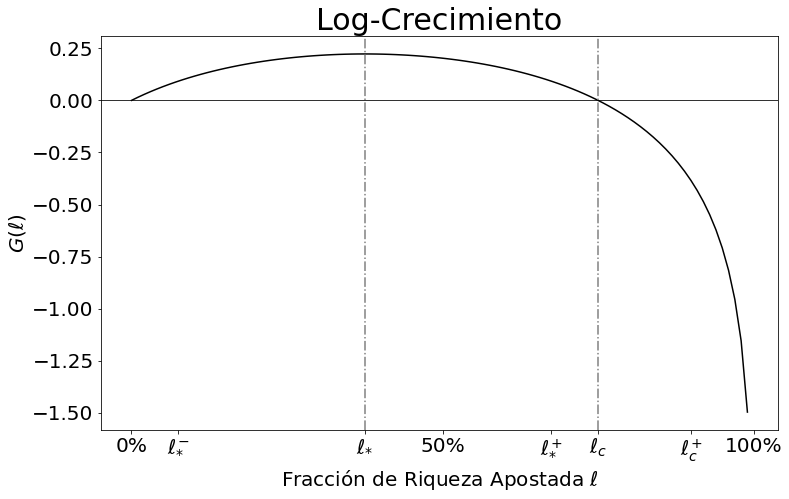

In [ ]:
# plot log-growth
fig, ax = plt.subplots()
ax.plot(ll, gl_aux, color='black')

# init params
lopt_minus = 0.075
lopt_plus = 0.675
lc_plus = 0.9


# show 0 threshold
plt.axhline(y=0, linewidth=0.8, color='black')
plt.axvline(x=aux_opt['x_opt'], color='gray', linestyle='-.')
plt.axvline(x=lc,  color='gray', linestyle='-.')

# pretty graph
plt.ylabel('$G(\ell)$', fontsize=20)
plt.xlabel('Fracción de Riqueza Apostada $\ell$', fontsize=20)
plt.title('Log-Crecimiento', fontsize=30)

ax.set_xticks([0, lopt_minus, l_opt, 0.5, lopt_plus, lc, lc_plus, 1])
ax.set_xticklabels(["0%", '$\ell_{*}^{-}$', '$\ell_{*}$',  "50%", '$\ell_{*}^{+}$', '$\ell_{c}$', '$\ell_{c}^{+}$', "100%"])
ax.tick_params(axis='both', which='major', labelsize=50)

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
ax.tick_params(axis='both', which='major', labelsize=20)

# save plot #
# generate figure folder
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate sub folder
final_folder = "Figures_Colab/FinancialModel/"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
plt.savefig(final_folder + "log_growth.png", bbox_inches='tight')   


plt.show()

## Properties of the Kelly Criterion

- Here we validate the theorem which states that:
  1. If $G(\ell) > 0$ then $\lim_{n \to \infty} W_{n} = \infty$ almost surely.
  2. If $G(\ell) < 0$ then $\lim_{n \to \infty} W_{n} = 0$ almost surely.
  3. If $G(\ell) = 0$ then $\lim_{n \to \infty} \sup W_{n} = \infty$ and $\lim_{n \to \infty} \inf W_{n} = 0$ almost surely.

- As well, we also verificate the theorem that says that the Kelly Criterion will overcome any other strategy in the long term.
i.e. $$\lim_{n \to \infty} \frac{W_{n}(\ell_{*})}{W_{n}(\ell)} = \infty, \ \forall \ell \neq \ell_{*}.$$

- For this, we simulate $10^{3}$ Bernoulli trails with $\theta = p = 1/2$ and $𝓸_{d} = 5$.

In [ ]:
# init params
N = 1000
rng = np.random.default_rng(42)

# simulate bernoulli trails
results_sim = rng.binomial(n=1, p=p_aux, size=N)

# generate dataframe
df_sim_kelly = (
    # generate dataframe
    pd.DataFrame({
        'trail': range(1,N+1),
        'result': results_sim,
        'l_opt_minus': eval_bet(lopt_minus, results_sim, o_aux),    
        'l_opt': eval_bet(l_opt, results_sim, o_aux),    
        'l_opt_plus': eval_bet(lopt_plus, results_sim, o_aux),    
        'l_c': eval_bet(lc, results_sim, o_aux),    
        'l_c_plus': eval_bet(lc_plus, results_sim, o_aux)    
    })
    # pivot longer
    .melt(
        id_vars='trail',
        value_vars=['l_opt_minus', 'l_opt', 'l_opt_plus', 'l_c', 'l_c_plus'],
        var_name='strategy',
        value_name='wealth'
    )
    # generate wealth
    .assign(
        cumm_wealth = lambda x: x.groupby('strategy').\
            transform(lambda x: np.cumprod(x+1))['wealth']
    )
    # concat matchweek '0' with wealth = 1 to dataframe
    .groupby('strategy')
    .apply(
        lambda x: x.append({'strategy': x.name, 'cumm_wealth': 1, 'trail': 0}, ignore_index=True)
    )
    .apply(lambda x: x.reset_index(drop=True))
    .sort_values(['strategy', 'trail'])
    .reset_index(drop=True)
)



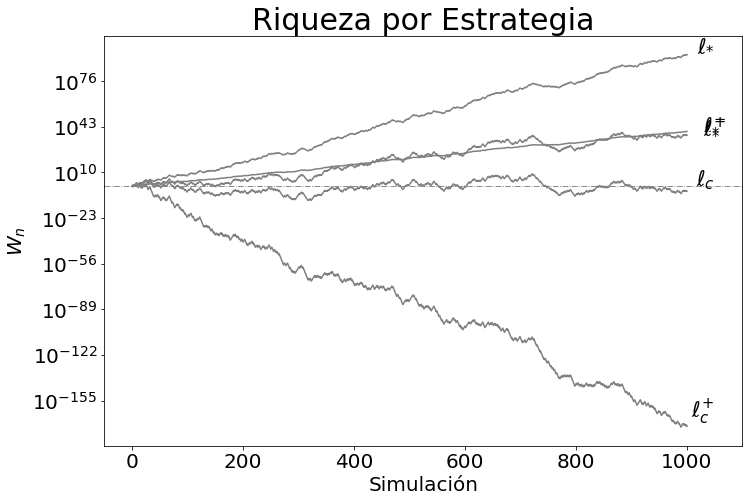

In [ ]:
# init plot
fig, ax = plt.subplots()

# plot lines
df_sim_kelly.set_index('trail', inplace=True)
df_sim_kelly.groupby('strategy')['cumm_wealth'].plot(color='gray', ax=ax)

# make space 4 labels
MOVEMENT = 50
left, right = plt.xlim()
plt.xlim((left, right + MOVEMENT))
    
# labels
last_sim = df_sim_kelly.groupby('strategy').tail(1)
ss = ['$\ell_{c}$', '$\ell_{c}^{+}$', '$\ell_{*}$', '$\ell_{*}^{-}$', '$\ell_{*}^{+}$']
n_plot = len(ss)
txt_ss = [plt.text(N + MOVEMENT, last_sim.iloc[i, 2], ss[i], fontsize=21) for i in range(n_plot)]

adjust_text(
    txt_ss,
    only_move={'points':'y', 'text':'y'}, 
    # autoalign='xy',
    expand_objects=(20, 40),
    force_points=1e+2,
    force_objects=1e+2,
    force_text=1e+1,
    lim=100
)

# show 0 threshold
plt.axhline(y=1, linewidth=0.9, color='gray', linestyle='-.')

# pretty graph
plt.ylabel('$W_{n}$', fontsize=20)
plt.xlabel('Simulación', fontsize=20)
plt.title('Riqueza por Estrategia', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.yscale('log')

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
ax.tick_params(axis='both', which='major', labelsize=20)    

# save plot #
# generate figure folder
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate sub folder
final_folder = "Figures_Colab/FinancialModel/"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
plt.savefig(final_folder + "simulate_fiex_log_growth.png", bbox_inches='tight')   


plt.show()

# Get English Premier League database & estimated probabilities for each outcome of each game per matchweek

In [ ]:
# main
df_all = get_df(type_pred='dropout')
df_validation = df_all.query("season == 20 & matchweek <= 18")
df_test = df_all.query("season == 20 & matchweek > 18")

# get dictionaries
dict_validation = get_games_dict(df_validation)
dict_test = get_games_dict(df_test)

# look database
df_all

,id_game,season,matchweek,date,hometeam,awayteam,market_tracktake,result,result_categoric,probas,odds
0,1,14,2,2014-08-23,aston_villa,newcastle,0.001314,0,h,0.224991,2.60
2590,1,14,2,2014-08-23,aston_villa,newcastle,0.001314,1,d,0.236272,3.40
5180,1,14,2,2014-08-23,aston_villa,newcastle,0.001314,0,a,0.538737,3.10
1,2,14,2,2014-08-23,chelsea,leicester,-0.010169,1,h,0.855519,1.25
2591,2,14,2,2014-08-23,chelsea,leicester,-0.010169,0,d,0.109470,7.50
...,...,...,...,...,...,...,...,...,...,...,...
5178,2589,20,38,2021-05-23,west_ham,southampton,0.017422,0,d,0.304169,4.10
7768,2589,20,38,2021-05-23,west_ham,southampton,0.017422,0,a,0.251111,5.03
2589,2590,20,38,2021-05-23,wolves,man_united,0.014287,0,h,0.319910,2.59
5179,2590,20,38,2021-05-23,wolves,man_united,0.014287,0,d,0.261290,3.78


# Best Fractional Bet for the database

- In the thesis is stated that by the fact we _estimate_ probabilities and the real proabilities aren't known, is preferable to underbet than overbet in a _favorable game_. Therefore we should use a fraction of the stake suggested by the Kelly Criterion.

- So, we can aproximate the "optimal" fraction with simulated strategies over the validation set.

## Simulate Bets

- For the validation database, we will simulate $N$ bets with a dirichlet distribution, i.e. $B \sim Dir((1 ,1 , \dots, 1)')$ to find the optimal value for the fractional Kelly. 

- We are taking unitary concentration parameters $\alpha_i = 1$ because this can be thought as complete ignorance, in the bayesian world. 


In [ ]:
# initial params
N = 100
fract = np.linspace(0.01, 1, N)

# generate simulations for each value of the bet
median_wn = [
             median_simulation_wealth(
                 fractional=f,
                 kforce=1,
                 tournment=dict_validation,
                 n_sim=200,
                 seed=10
             )
             for f in fract
  ]
median_wn = np.array(median_wn)
best_fraction = fract[median_wn.argmax()]

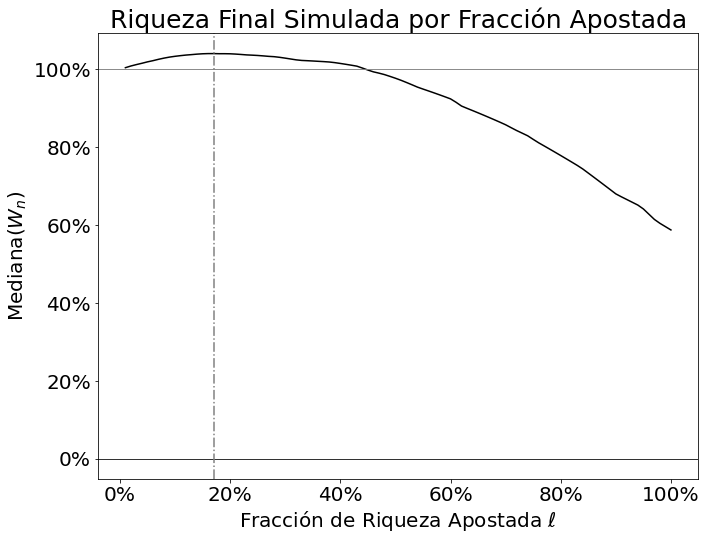

In [ ]:
# plot
fig, ax = plt.subplots()
ax.plot(fract, median_wn, color='black')

# show 0 threshold
plt.axhline(y=0, linewidth=0.8, color='black')

# show maximum
plt.axvline(x=best_fraction, color='gray', linestyle='-.')
plt.axhline(y=1, color='gray', linewidth=0.9)

# pretty graph
plt.ylabel('Mediana$(W_{n})$', fontsize=20)
plt.xlabel('Fracción de Riqueza Apostada $\ell$', fontsize=20)
plt.title('Riqueza Final Simulada por Fracción Apostada', fontsize=25)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
ax.tick_params(axis='both', which='major', labelsize=20)

# save plot #
# generate figure folder
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate sub folder
final_folder = "Figures_Colab/FinancialModel/"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
plt.savefig(final_folder + "sim_fract_validation.png", bbox_inches='tight')   

plt.show()

## Fractional kelly & fractional markowitz

- Look performance of the Kelly & Markowitz strategies with distinct fractional values for the validation set.

- **Caution:** The strategies look impresive _because_ the probabilities estimated in the validation set were tuned in this same set. In the test set, things can be different.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: Optimization for Kelly wasn't succesful
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: Optimization for Kelly wasn't succesful
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: Use

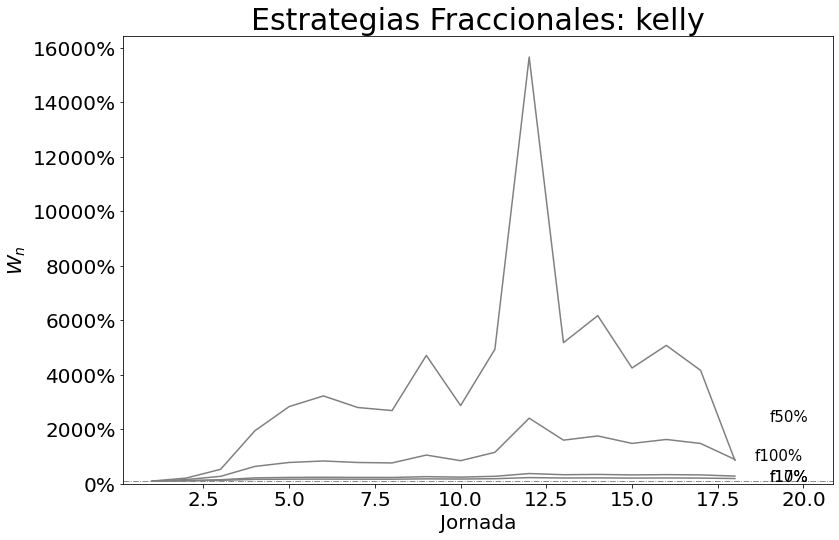

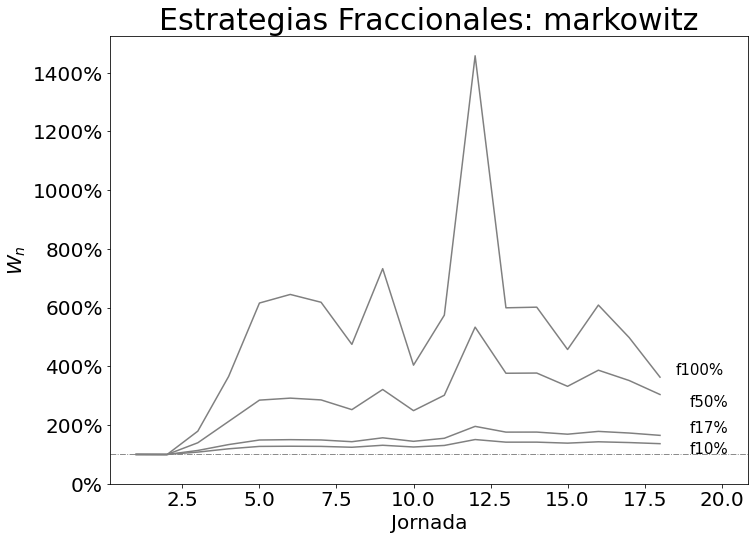

()

In [ ]:
# init params
list_fract = [1, 0.5, best_fraction, 0.10]

# fractional models
fractional_models(
    tournment=dict_validation, 
    df=df_validation,
    type_model='kelly',
    fractions=list_fract
)
fractional_models(
    tournment=dict_validation, 
    df=df_validation,
    type_model='markowitz',
    fractions=list_fract
)


In [ ]:
## look Kelly & Markowitz Optimization for validation set
kelly_general_validation = portfolios_optimization(
    tournment=dict_validation,
    df=df_validation,
    stake_model='kelly',
    fractional=1,
    verbose=False
)

# look 
kelly_general_validation['metrics']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: Optimization for Kelly wasn't succesful


,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,kelly,multiple,2,1,1.108816,2.108816,17,0.997781,0.164685,0.018340,0.758365,0.713102,0.884191,0.355010,4,0.235294,1.469505,-0.164320
1,kelly,multiple,3,1,1.521465,5.317307,16,0.996527,0.159659,0.014847,0.909854,0.949244,1.088459,0.462244,6,0.375000,1.461386,-0.159105
2,kelly,multiple,4,1,2.660926,19.466267,18,0.988727,0.269025,0.019636,0.747963,1.038919,1.929317,0.412405,8,0.444444,2.407234,-0.230168
3,kelly,multiple,5,1,0.456413,28.350917,14,0.999945,0.304398,0.014691,0.795096,0.858066,1.164669,0.379887,6,0.428571,0.737886,-0.304381
4,kelly,multiple,6,1,0.137849,32.259053,17,0.999996,0.225425,0.017676,0.566037,0.282639,0.249331,0.149963,5,0.294118,0.689798,-0.132097
5,kelly,multiple,7,1,-0.131538,28.015777,17,0.999997,0.228741,0.016249,0.643928,0.391760,0.370140,0.215130,5,0.294118,0.275934,-0.228740
6,kelly,multiple,8,1,-0.040721,26.874959,18,0.959228,0.161491,0.013538,0.622682,0.368687,0.350577,0.191506,2,0.111111,0.661452,-0.143937
7,kelly,multiple,9,1,0.753606,47.128080,18,0.999283,0.285199,0.021160,0.617924,0.295050,0.227993,0.173073,8,0.444444,0.411827,-0.105658
8,kelly,multiple,10,1,-0.390800,28.710450,17,0.908110,0.222624,0.015883,0.548879,0.358314,0.426161,0.174655,3,0.176471,0.234052,-0.202167
9,kelly,multiple,11,1,0.720401,49.393496,13,0.999850,0.286414,0.017864,0.593062,0.266730,0.202275,0.154237,6,0.461538,0.463920,-0.061987


# Complete Portfolio Optimization

- Here starts the betting strategies for the EPL.

- We considere _all posible outcomes for each game in every matchweek_. There aren't restrictions in betting. For example: bet that the house wins and at the same time that there is a draw. Inclusive it can bet in all possible outcomes for one game in a degenerate case, like finding arbitrage.

## Kelly Criterion

The Kelly Criterion is founded:
$$\text{argmax}_{\underline{\ell}} \left\{ \sum_{j}^{N}p_{j} \log\left (𝟙 + \underline{w}_{j}'\underline{\ell} - \sum^{M}_{i}\ell_{i} \right) \right\} \quad \text{s.t.} \quad \sum_{i}^{M}\ell_{i} \leq 1,\ \ell_{i} \geq 0.$$

Where:
* $N = \prod_{i}^{r}m_{i} = 3^{10} \approx 59,000$, are all the posibilities of outcomes for all the games played in a matchweek. In this case $m_i = 3$ (number of possible outcomes in game-i) and $r = 10$ (total games).

* $M = \sum_{i}^{r}m_{i} = 3*10$, are all the outcomes.

* $\underline{w}_{j}$ the reward of the $j$-possibility. i.e. $(w_j)_i = 𝓸^{(d)}_{i}$ if $i \in \omega_{j} \in \Omega$; $(w_j)_i = 0$ elsewhere.


### Optimize Complete Kelly Criterion: normal & fractional

Optimize Kelly Criterion for complete stake and fractional stake.


In [ ]:
# optimization
print("--------General Kelly Criterion-------")
kelly_general = portfolios_optimization(
    tournment=dict_test,
    df=df_test,
    stake_model='kelly',
    fractional=1
)

print("\n--------General Fractional Kelly Criterion-------")
kelly_general_fractional = portfolios_optimization(
    tournment=dict_test,
    df=df_test,
    stake_model='kelly',
    fractional=best_fraction # found at the start of the notebook
)


--------General Kelly Criterion-------

Optimization for matchweek19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log



                     num stakes: 20 
                     wage betted: 97.0%
                     percent hitted: 25.0%
                     final wealth: 52.0%                
                


Optimization for matchweek20

                     num stakes: 17 
                     wage betted: 87.0%
                     percent hitted: 35.0%
                     final wealth: 39.0%                
                


Optimization for matchweek21

                     num stakes: 20 
                     wage betted: 100.0%
                     percent hitted: 30.0%
                     final wealth: -33.0%                
                


Optimization for matchweek22

                     num stakes: 14 
                     wage betted: 86.0%
                     percent hitted: 36.0%
                     final wealth: -12.0%                
                


Optimization for matchweek23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: Optimization for Kelly wasn't succesful



                     num stakes: 11 
                     wage betted: 100.0%
                     percent hitted: 36.0%
                     final wealth: 9.0%                
                


Optimization for matchweek24

                     num stakes: 20 
                     wage betted: 100.0%
                     percent hitted: 30.0%
                     final wealth: -24.0%                
                


Optimization for matchweek25

                     num stakes: 16 
                     wage betted: 89.0%
                     percent hitted: 31.0%
                     final wealth: 42.0%                
                


Optimization for matchweek26

                     num stakes: 18 
                     wage betted: 99.0%
                     percent hitted: 22.0%
                     final wealth: -43.0%                
                


Optimization for matchweek27

                     num stakes: 12 
                     wage betted: 100.0%
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log



                     num stakes: 20 
                     wage betted: 17.0%
                     percent hitted: 25.0%
                     final wealth: 9.0%                
                


Optimization for matchweek20

                     num stakes: 17 
                     wage betted: 15.0%
                     percent hitted: 35.0%
                     final wealth: 7.0%                
                


Optimization for matchweek21

                     num stakes: 20 
                     wage betted: 17.0%
                     percent hitted: 30.0%
                     final wealth: -6.0%                
                


Optimization for matchweek22

                     num stakes: 14 
                     wage betted: 15.0%
                     percent hitted: 36.0%
                     final wealth: -2.0%                
                


Optimization for matchweek23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: Optimization for Kelly wasn't succesful



                     num stakes: 11 
                     wage betted: 17.0%
                     percent hitted: 36.0%
                     final wealth: 2.0%                
                


Optimization for matchweek24

                     num stakes: 20 
                     wage betted: 17.0%
                     percent hitted: 30.0%
                     final wealth: -4.0%                
                


Optimization for matchweek25

                     num stakes: 16 
                     wage betted: 15.0%
                     percent hitted: 31.0%
                     final wealth: 7.0%                
                


Optimization for matchweek26

                     num stakes: 18 
                     wage betted: 17.0%
                     percent hitted: 22.0%
                     final wealth: -7.0%                
                


Optimization for matchweek27

                     num stakes: 12 
                     wage betted: 17.0%
                    

In [ ]:
# look complete tables
kelly_general['metrics']


,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,kelly,multiple,19,1,0.516383,1.516383,20,0.972056,0.221702,0.020816,0.748867,0.635609,0.720395,0.320113,5,0.250000,0.824173,-0.215507
1,kelly,multiple,20,1,0.391516,2.110071,17,0.874428,0.180087,0.015569,0.362155,0.132184,0.133219,0.067397,6,0.352941,0.354789,-0.157473
2,kelly,multiple,21,1,-0.328320,1.417292,20,0.996528,0.181396,0.019442,0.568344,0.482963,0.722112,0.224661,6,0.300000,0.255699,-0.180766
3,kelly,multiple,22,1,-0.118152,1.249837,14,0.862175,0.155524,0.017398,0.423406,0.163671,0.149428,0.086666,5,0.357143,0.244041,-0.113885
4,kelly,multiple,23,1,0.091405,1.364078,11,0.999973,0.158979,0.018291,0.603365,0.339700,0.316979,0.163915,4,0.363636,0.373655,-0.158975
5,kelly,multiple,24,1,-0.235927,1.042256,20,0.999977,0.148391,0.017592,0.791165,0.600280,0.575670,0.333777,6,0.300000,0.260216,-0.148388
6,kelly,multiple,25,1,0.419471,1.479451,16,0.886103,0.167268,0.018644,0.492895,0.227333,0.212724,0.120038,5,0.312500,0.337709,-0.148217
7,kelly,multiple,26,1,-0.429367,0.844224,18,0.989724,0.212834,0.017401,0.647564,0.414200,0.409124,0.216460,4,0.222222,0.193537,-0.210647
8,kelly,multiple,27,1,1.053238,1.733392,12,0.999943,0.175731,0.020369,0.736278,0.522181,0.502990,0.251780,6,0.500000,0.658954,-0.151530
9,kelly,multiple,28,1,0.013157,1.756199,18,0.999974,0.269539,0.014126,0.579363,0.271438,0.219504,0.154300,7,0.388889,0.353087,-0.132519


In [ ]:
# look fractional kelly metrics
kelly_general_fractional['metrics']

,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,kelly,multiple,19,0.17,0.087785,1.087785,20,0.165249,0.221702,0.003539,0.748867,0.108054,0.020819,0.094379,5,0.250000,0.140109,-0.036636
1,kelly,multiple,20,0.17,0.066558,1.160186,17,0.148653,0.180087,0.002647,0.362155,0.022471,0.003850,0.020397,6,0.352941,0.060314,-0.026770
2,kelly,multiple,21,0.17,-0.055814,1.095430,20,0.169410,0.181396,0.003305,0.568344,0.082104,0.020869,0.070537,6,0.300000,0.043469,-0.030730
3,kelly,multiple,22,0.17,-0.020086,1.073428,14,0.146570,0.155524,0.002958,0.423406,0.027824,0.004318,0.025400,5,0.357143,0.041487,-0.019360
4,kelly,multiple,23,0.17,0.015539,1.090108,11,0.169995,0.158979,0.003109,0.603365,0.057749,0.009161,0.052044,4,0.363636,0.063521,-0.027026
5,kelly,multiple,24,0.17,-0.040108,1.046386,20,0.169996,0.148391,0.002991,0.791165,0.102048,0.016637,0.090457,6,0.300000,0.044237,-0.025226
6,kelly,multiple,25,0.17,0.071310,1.121004,16,0.150638,0.167268,0.003169,0.492895,0.038647,0.006148,0.035081,5,0.312500,0.057410,-0.025197
7,kelly,multiple,26,0.17,-0.072992,1.039179,18,0.168253,0.212834,0.002958,0.647564,0.070414,0.011824,0.062920,4,0.222222,0.032901,-0.035810
8,kelly,multiple,27,0.17,0.179051,1.225245,12,0.169990,0.175731,0.003463,0.736278,0.088771,0.014536,0.078876,6,0.500000,0.112022,-0.025760
9,kelly,multiple,28,0.17,0.002237,1.227985,18,0.169996,0.269539,0.002401,0.579363,0.046145,0.006344,0.042210,7,0.388889,0.060025,-0.022528


### Model evaluation & Performance

In [ ]:
# evaluate general kelly
eval_kelly_general = model_summary(kelly_general)
eval_kelly_general_fract = model_summary(kelly_general_fractional)

# look both models
pd.DataFrame([eval_kelly_general, eval_kelly_general_fract])


,model,final_wealth,total_bets,mean_num_bets_per_matchweek,mean_wage_bet_per_matchweek,total_hits,mean_sharpe,mean_log_growth,mean_volatility,pval_bets,pval_wealth
0,kelly_multiple_1,0.031642,319,15.95,0.978123,0.304075,0.642523,0.234772,0.540464,0.424446,0.411158
1,kelly_multiple_0.17,1.020087,319,15.95,0.166281,0.304075,0.642523,0.070269,0.015619,0.424446,0.411158


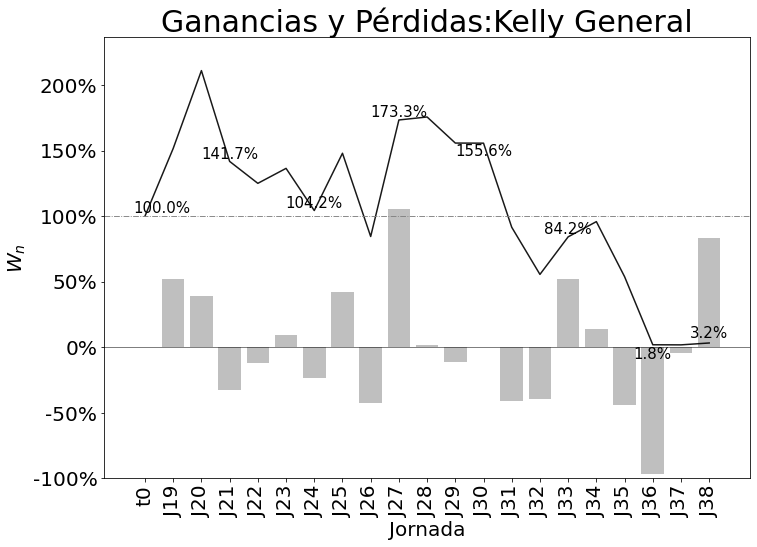

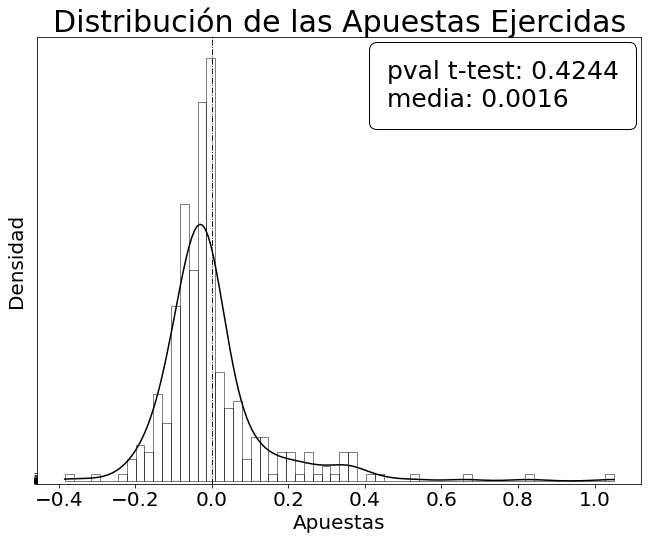

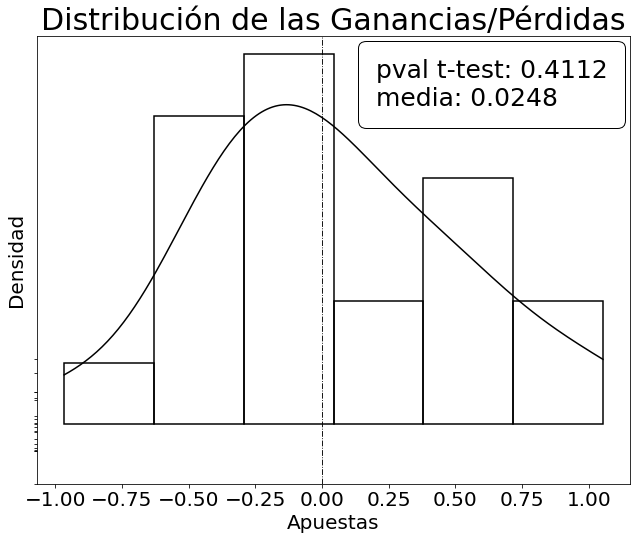

()

In [ ]:
# look performance
show_performance(
    model=kelly_general, 
    model_summary=eval_kelly_general,
    model_name='Kelly General'
)

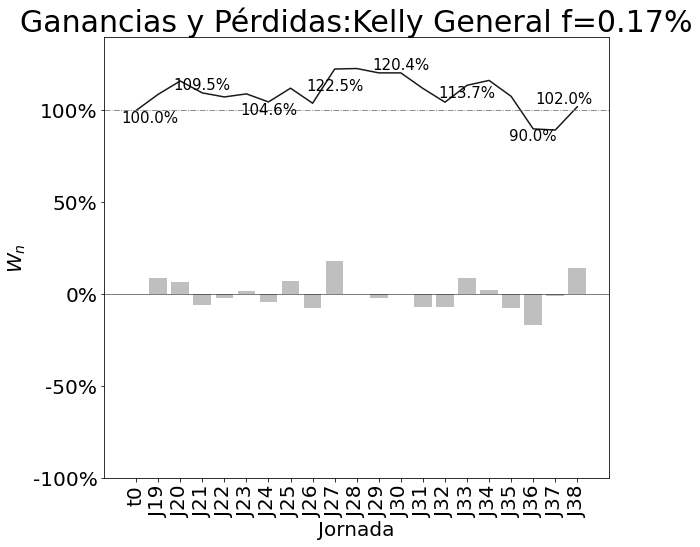

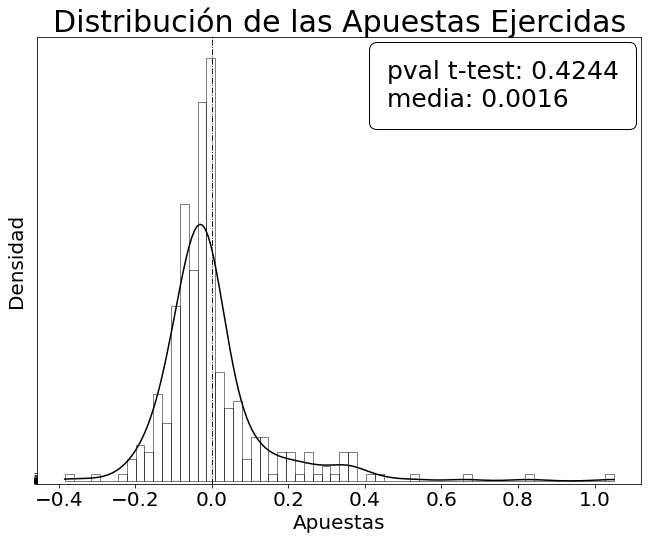

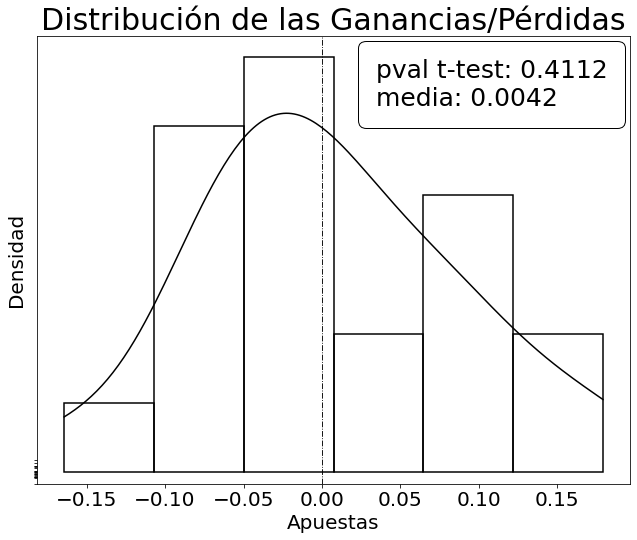

()

In [ ]:
# look performance
show_performance(
    model=kelly_general_fractional, 
    model_summary=eval_kelly_general_fract,
    model_name=f"Kelly General f={best_fraction}%"
)

## Sharpe Ratio

The Sharpe Ratio Criterion is founded where:
$$\text{argmax}_{\underline{\ell}} \left\{\frac{\underline{\ell}'\underline{\mu}}{\sqrt{\underline{\ell}'\Sigma \underline{\ell}}} \right \}\quad \text{s.t.} \quad \sum_{i}^{M}\ell_{i} = 1,\ \ell_{i} \geq 0.$$

Where:
  - $\mu = 𝔼[\underline{\rho}] = (\underline{𝓸}^{d} - 𝟙) * \underline{p}$ is the expected value of each outcome. 
  - $\Sigma = \text{Var}(\underline{\rho}) = \text{diag}(\Sigma_1, \Sigma_2, \dots, \Sigma_{r})$ is the var covariance of all the games. We assume that the games are uncorraleted, but outcomes.

However, the Sharpe Ratio can be non-convex. So, we reformulate the optimization in the dimension M+1, so the objective function is convex according to Reha Tutuncu:

$$\text{argmin}_{(\underline{f}, \kappa)} \left \{\underline{f}'\Sigma \underline{f}  \right\}\quad \text{s.t.} \quad  \sum_{i}^{M}f_{i} = \kappa,\ f_{i} \geq 0, \ \underline{f}' \mu = 1.$$

Where $\underline{f} = \kappa \underline{\ell}$, with $\kappa > 0$.



### Optimize Complete Sharpe Criterion: normal & fractional

Optimize Sharpe Ratio for complete stake and fractional stake.


In [ ]:
# optimization
print("--------General Mktz Criterion-------")
mktz_general = portfolios_optimization(
    tournment=dict_test,
    df=df_test,
    stake_model='markowitz',
    fractional=1
)

print("\n--------General Mktz Fractional Criterion-------")
mktz_general_fractional = portfolios_optimization(
    tournment=dict_test,
    df=df_test,
    stake_model='markowitz',
    fractional=best_fraction
)


--------General Mktz Criterion-------

Optimization for matchweek19

                     num stakes: 20 
                     wage betted: 100.0%
                     percent hitted: 25.0%
                     final wealth: 10.0%                
                


Optimization for matchweek20

                     num stakes: 17 
                     wage betted: 100.0%
                     percent hitted: 35.0%
                     final wealth: 30.0%                
                


Optimization for matchweek21

                     num stakes: 20 
                     wage betted: 100.0%
                     percent hitted: 30.0%
                     final wealth: -20.0%                
                


Optimization for matchweek22

                     num stakes: 14 
                     wage betted: 100.0%
                     percent hitted: 36.0%
                     final wealth: -1.0%                
                


Optimization for matchweek23

                     n

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in sqrt



                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 40.0%
                     final wealth: 0.0%                
                


Optimization for matchweek25

                     num stakes: 16 
                     wage betted: 100.0%
                     percent hitted: 31.0%
                     final wealth: 45.0%                
                


Optimization for matchweek26

                     num stakes: 18 
                     wage betted: 100.0%
                     percent hitted: 22.0%
                     final wealth: -28.0%                
                


Optimization for matchweek27

                     num stakes: 18 
                     wage betted: 100.0%
                     percent hitted: 33.0%
                     final wealth: 60.0%                
                


Optimization for matchweek28

                     num stakes: 3 
                     wage betted: 100.0%
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in sqrt



                     num stakes: 10 
                     wage betted: 17.0%
                     percent hitted: 40.0%
                     final wealth: 0.0%                
                


Optimization for matchweek25

                     num stakes: 16 
                     wage betted: 17.0%
                     percent hitted: 31.0%
                     final wealth: 8.0%                
                


Optimization for matchweek26

                     num stakes: 18 
                     wage betted: 17.0%
                     percent hitted: 22.0%
                     final wealth: -5.0%                
                


Optimization for matchweek27

                     num stakes: 18 
                     wage betted: 17.0%
                     percent hitted: 33.0%
                     final wealth: 10.0%                
                


Optimization for matchweek28

                     num stakes: 3 
                     wage betted: 17.0%
                     

In [ ]:
# look complete tables
mktz_general['metrics']


,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,markowitz,multiple,19,1,0.097826,1.097826,20,1.000000,0.193410,0.022351,0.843117,0.448377,0.282820,0.278434,5,0.250000,0.447321,-0.193410
1,markowitz,multiple,20,1,0.301082,1.428362,17,1.000000,0.214836,0.017633,0.367596,0.133642,0.132173,0.062022,6,0.352941,0.314299,-0.214836
2,markowitz,multiple,21,1,-0.195307,1.149393,20,1.000000,0.153391,0.018696,0.658767,0.275309,0.174654,0.181025,6,0.300000,0.198301,-0.153391
3,markowitz,multiple,22,1,-0.012073,1.135517,14,1.000000,0.169738,0.019978,0.427832,0.176058,0.169341,0.058689,5,0.357143,0.308923,-0.113392
4,markowitz,multiple,23,1,0.073521,1.219001,17,1.000000,0.248668,0.018660,0.694717,0.233701,0.113163,0.164836,5,0.294118,0.326510,-0.119301
5,markowitz,multiple,24,1,0.002012,1.221454,10,0.999631,0.774901,-0.001851,12.512026,0.001899,0.000000,0.001897,4,0.400000,0.224639,-0.145877
6,markowitz,multiple,25,1,0.448299,1.769031,16,1.000000,0.155586,0.021073,0.498813,0.234750,0.221480,0.104504,5,0.312500,0.368919,-0.155586
7,markowitz,multiple,26,1,-0.278637,1.276113,18,1.000000,0.202781,0.018068,0.678748,0.296226,0.190471,0.189415,4,0.222222,0.245365,-0.134469
8,markowitz,multiple,27,1,0.599089,2.040620,18,1.000000,0.130755,0.019837,0.835709,0.318081,0.144865,0.226298,6,0.333333,0.281871,-0.087935
9,markowitz,multiple,28,1,0.000035,2.040692,3,0.999996,0.704250,-0.000035,NaN,0.000035,0.000000,0.000035,1,0.333333,0.894765,-0.704248


In [ ]:
# look complete tables
mktz_general_fractional['metrics']

,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,markowitz,multiple,19,0.17,0.016630,1.016630,20,0.170000,0.193410,0.003800,0.843117,0.076224,0.008173,0.069891,5,0.250000,0.076045,-0.032880
1,markowitz,multiple,20,0.17,0.051184,1.068666,17,0.170000,0.214836,0.002998,0.367596,0.022719,0.003820,0.020640,6,0.352941,0.053431,-0.036522
2,markowitz,multiple,21,0.17,-0.033202,1.033184,20,0.170000,0.153391,0.003178,0.658767,0.046803,0.005047,0.043442,6,0.300000,0.033711,-0.026077
3,markowitz,multiple,22,0.17,-0.002052,1.031063,14,0.170000,0.169738,0.003396,0.427832,0.029930,0.004894,0.027169,5,0.357143,0.052517,-0.019277
4,markowitz,multiple,23,0.17,0.012499,1.043950,17,0.170000,0.248668,0.003172,0.694717,0.039729,0.003270,0.037434,5,0.294118,0.055507,-0.020281
5,markowitz,multiple,24,0.17,0.000342,1.044307,10,0.169937,0.774901,-0.000315,12.512026,0.000323,0.000000,0.000323,4,0.400000,0.038189,-0.024799
6,markowitz,multiple,25,0.17,0.076211,1.123895,16,0.170000,0.155586,0.003582,0.498813,0.039907,0.006401,0.036168,5,0.312500,0.062716,-0.026450
7,markowitz,multiple,26,0.17,-0.047368,1.070658,18,0.170000,0.202781,0.003072,0.678748,0.050358,0.005505,0.046631,4,0.222222,0.041712,-0.022860
8,markowitz,multiple,27,0.17,0.101845,1.179699,18,0.170000,0.130755,0.003372,0.835709,0.054074,0.004187,0.050764,6,0.333333,0.047918,-0.014949
9,markowitz,multiple,28,0.17,0.000006,1.179706,3,0.169999,0.704250,-0.000006,NaN,0.000006,0.000000,0.000006,1,0.333333,0.152110,-0.119722


### Model evaluation & Performance

An outstanding fact is that the maximization of the Sharpe Ratio can find the games where there is arbitrage. This is because the volatility of the matchweek can be reduced to 0 with a positive expectation, making the sharpe ratio tend to infinity. The _certain_ wealth is going to be the negative track take. 

In [ ]:
# evaluate general kelly
eval_mktz_general = model_summary(mktz_general)
eval_mktz_general_fract = model_summary(mktz_general_fractional)

# look both models
pd.DataFrame([eval_mktz_general, eval_mktz_general_fract])


,model,final_wealth,total_bets,mean_num_bets_per_matchweek,mean_wage_bet_per_matchweek,total_hits,mean_sharpe,mean_log_growth,mean_volatility,pval_bets,pval_wealth
0,markowitz_multiple_1,0.161096,323,16.15,0.999970,0.303406,1.406034,0.16428,0.132694,0.501309,0.502026
1,markowitz_multiple_0.17,0.966343,323,16.15,0.169995,0.303406,1.406034,0.03918,0.003835,0.501309,0.502026


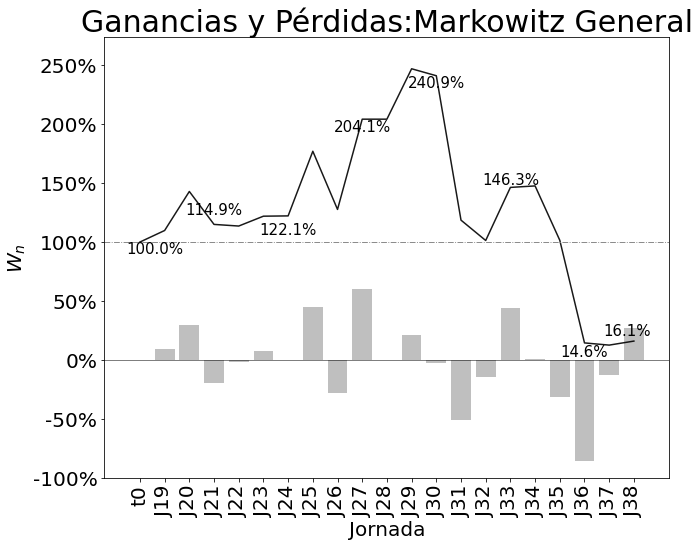

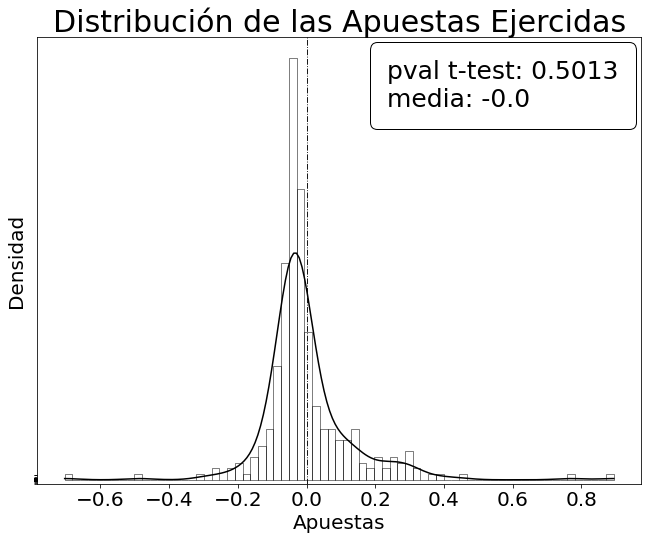

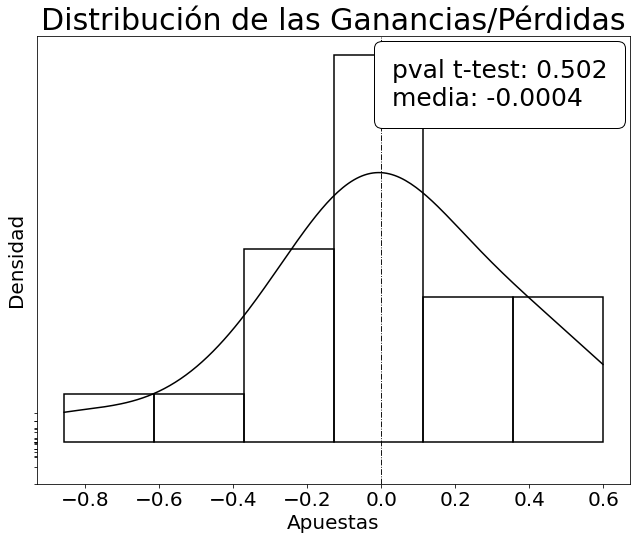

()

In [ ]:
# look performance
show_performance(
    model=mktz_general, 
    model_summary=eval_mktz_general,
    model_name='Markowitz General'
)

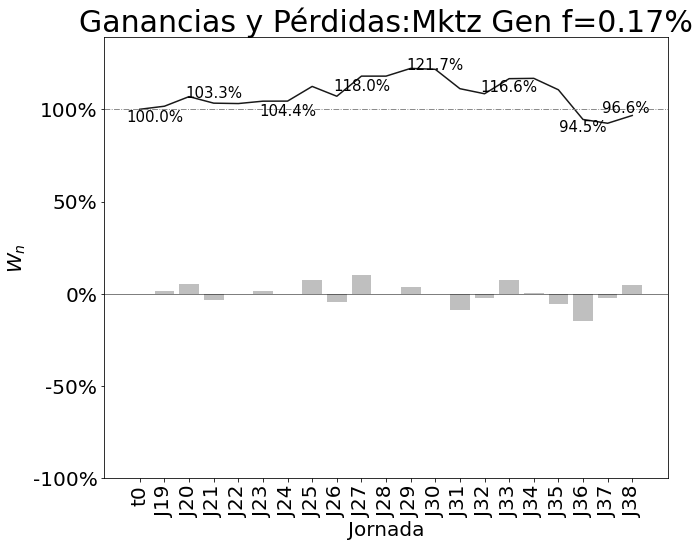

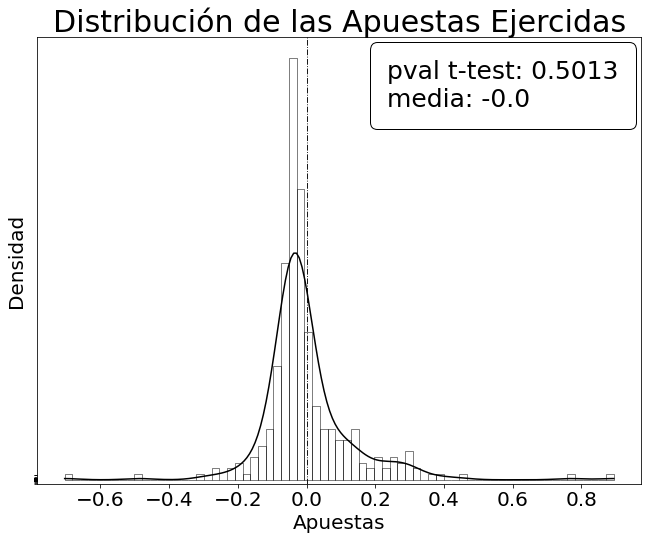

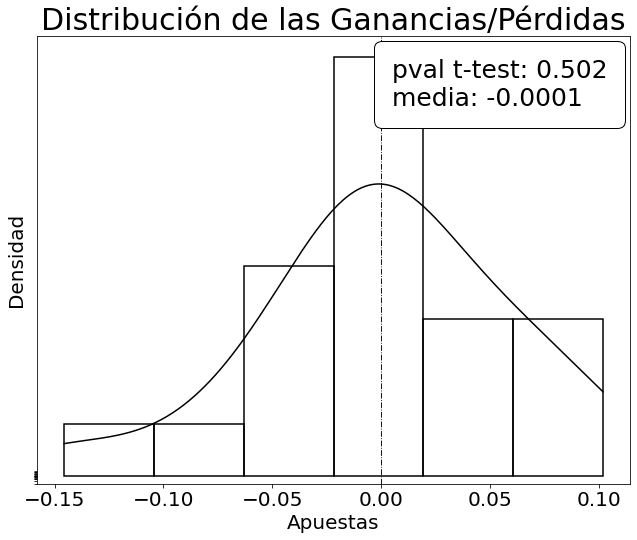

()

In [ ]:
# look performance
show_performance(
    model=mktz_general_fractional,   
    model_summary=eval_mktz_general_fract,
    model_name=f"Mktz Gen f={best_fraction}%"
)

#### Arbitrage

- In sports betting we can find arbitrage by the fact the market isn't efficient: for the same product, there exist distinct prices. In a very favorable scenario, if the odds taken for gambling present a negative track take (i.e. the sum of their inverse sum less than 1), betting exactly the inverse of this odds would yield a surely income.

- The Sharpe Ratio could find this values in the variance-covariance matrix, because this matrix is a block diagonal matrix. Because for a game, the random vector $\underline{\rho} = \text{diag}(\underline{o_{d}}) \underline{𝒎} - 𝟙$ where $\underline{𝒎} \sim Mult(1; p_1, p_2, p_3)$, has $ \text{Var}(\underline{\rho}) = \text{diag}(\underline{o_{d}}) (\underline{p} - \underline{p} \underline{p}')\text{diag}(\underline{o_{d}})$ and letting $\underline{\ell}_{*} = \underline{o}_{d}^{-1}$ we have $\underline{\ell}_{*}'\text{Var}(\underline{\rho}) \underline{\ell}_{*} = 0.$



In [ ]:
# arbitrage games
(
    mktz_general['bets']
    # subset
    .query("matchweek == 34")
    # get "probabilities" of the market
    .assign(
        inverse_odd = lambda x: 1/x['odds'],
        inverse_odd_reescale = \
          lambda x: 1/ (x['odds'] * x.groupby(['hometeam', 'awayteam'])['odds'].transform(lambda y: np.sum(1/y))),
        name_game = lambda x: x['hometeam'] + ' - ' + x['awayteam']
    )
    # select important columns
    [[
      'name_game', 'result_categoric', 'market_tracktake', 
      'probas', 'odds', 'inverse_odd', 'inverse_odd_reescale', 'bets'
      ]]
 
     # hierarchical index
    .set_index(['name_game', 'result_categoric'])
)


market_tracktake  ...      bets
name_game                         result_categoric                    ...          
brighton - leeds                  h                         0.023198  ...  0.000000
                                  d                         0.023198  ...  0.000000
                                  a                         0.023198  ...  0.000000
chelsea - fulham                  h                         0.018939  ...  0.000000
                                  d                         0.018939  ...  0.000000
                                  a                         0.018939  ...  0.000000
everton - aston_villa             h                        -0.008543  ...  0.487144
                                  d                        -0.008543  ...  0.272538
                                  a                        -0.008543  ...  0.240093
newcastle - arsenal               h                         0.020635  ...  0.000000
                                  d                         0.020635  ...  0.000000
                                  a                         0.020635  ...  0.000000
tottenham - sheffield_united      h                         0.009820  ...  0.000000
                                  d                         0.009820  ...  0.000000
                                  a                         0.009820  ...  0.000000
west_brom - wolves                h                         0.018384  ...  0.000000
                                  d                         0.018384  ...  0.000000
                                  a                         0.018384  ...  0.000000
burnley - west_ham                h                         0.018489  ...  0.000000
                                  d                         0.018489  ...  0.000000
                                  a                         0.018489  ...  0.000000
leicester - newcastle             h                         0.015344  ...  0.000000
                                  d                         0.015344  ...  0.000000
                                  a                         0.015344  ...  0.000000
leeds - tottenham                 h                         0.022746  ...  0.000000
                                  d                         0.022746  ...  0.000000
                                  a                         0.022746  ...  0.000000
sheffield_united - crystal_palace h                         0.016946  ...  0.000000
                                  d                         0.016946  ...  0.000000
                                  a                         0.016946  ...  0.000000

[30 rows x 6 columns]

# Incomplete Portfolio Optimization

Here we restrict the betting stakes to only the highest positive expectation outcome per game.

i.e. $$\Omega = \text{X}_{i=1}^{r}\left\{\omega_{j} | \text{argmax}_{j}\left \{𝓸^{(d)}_{j} p_{j} - 1\right \}, \quad \omega_{k} \in \Omega_{i}  \right\}.$$

**Note:** We _don't_ restrict that the expected value should be positive because we expected the optimization get rid of this games.

## Retraive Information 

In [ ]:
# get database & dictionary
# best possible outcome
df_test_restricted = (
    df_test
    # get expected value for each event
    .assign(
        rho = lambda x: x['odds'] * x['probas'] - 1
    )
    # sort games in ascending order with respected the expected gain
    .sort_values( 
        by=['id_game', 'rho'], ascending=[True, False]
    )
    # get the best event by game
    .groupby(
        'id_game'
    )
    .first(
        
    )
    # reset index
    .reset_index(
    
    )
)

# get dictionary
dict_test_restricted = get_games_dict(df_test_restricted)

# get negative expected gain games outcomes
df_neg_restricted = df_test_restricted[df_test_restricted['rho'] < 0]

# look 
print("Highest expected value outcome games:\n", df_test_restricted)

# look how many have negative expectation
print("No. of games with negative exepctation: ",  np.sum(df_test_restricted['rho'] < 0))

# print games with this negative outcomes
print("Games with negative exepctation: \n", df_neg_restricted)


Highest expected value outcome games:
      id_game  season  matchweek  ...    probas   odds       rho
0       2391      20         19  ...  0.318550   3.49  0.111739
1       2392      20         19  ...  0.239386   6.50  0.556011
2       2393      20         19  ...  0.206560   6.50  0.342643
3       2394      20         19  ...  0.117684  17.00  1.000627
4       2395      20         19  ...  0.250459   6.50  0.627980
..       ...     ...        ...  ...       ...    ...       ...
195     2586      20         38  ...  0.101661  18.32  0.862422
196     2587      20         38  ...  0.753885   1.47  0.108210
197     2588      20         38  ...  0.484610   2.45  0.187294
198     2589      20         38  ...  0.251111   5.03  0.263088
199     2590      20         38  ...  0.418800   2.75  0.151700

[200 rows x 12 columns]
No. of games with negative exepctation:  4
Games with negative exepctation: 
      id_game  season  matchweek  ...    probas  odds       rho
39      2430      20       

## Restricted Kelly Criterion


### Optimize Restricted Kelly Criterion: normal & fractional

Optimze Kelly Criterion for stake and fractional stake.


In [ ]:
# optimization
print("--------Restricted Kelly Criterion-------")
kelly_restricted = portfolios_optimization(
    tournment=dict_test_restricted,
    df=df_test_restricted,
    stake_model='kelly',
    fractional=1
)

print("\n--------Restricted Fractional Kelly Criterion-------")
kelly_restricted_fractional = portfolios_optimization(
    tournment=dict_test_restricted,
    df=df_test_restricted,
    stake_model='kelly',
    fractional=best_fraction
)


--------Restricted Kelly Criterion-------

Optimization for matchweek19

                     num stakes: 10 
                     wage betted: 75.0%
                     percent hitted: 20.0%
                     final wealth: 67.0%                
                


Optimization for matchweek20

                     num stakes: 10 
                     wage betted: 64.0%
                     percent hitted: 50.0%
                     final wealth: 52.0%                
                


Optimization for matchweek21

                     num stakes: 10 
                     wage betted: 88.0%
                     percent hitted: 30.0%
                     final wealth: -23.0%                
                


Optimization for matchweek22

                     num stakes: 9 
                     wage betted: 61.0%
                     percent hitted: 22.0%
                     final wealth: -25.0%                
                


Optimization for matchweek23

                     n

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log



                     num stakes: 10 
                     wage betted: 97.0%
                     percent hitted: 20.0%
                     final wealth: -48.0%                
                


Optimization for matchweek25

                     num stakes: 10 
                     wage betted: 69.0%
                     percent hitted: 30.0%
                     final wealth: 31.0%                
                


Optimization for matchweek26

                     num stakes: 10 
                     wage betted: 85.0%
                     percent hitted: 20.0%
                     final wealth: -33.0%                
                


Optimization for matchweek27

                     num stakes: 9 
                     wage betted: 88.0%
                     percent hitted: 33.0%
                     final wealth: 24.0%                
                


Optimization for matchweek28

                     num stakes: 10 
                     wage betted: 76.0%
                 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log



                     num stakes: 10 
                     wage betted: 15.0%
                     percent hitted: 30.0%
                     final wealth: -4.0%                
                


Optimization for matchweek22

                     num stakes: 9 
                     wage betted: 10.0%
                     percent hitted: 22.0%
                     final wealth: -4.0%                
                


Optimization for matchweek23

                     num stakes: 10 
                     wage betted: 15.0%
                     percent hitted: 40.0%
                     final wealth: 5.0%                
                


Optimization for matchweek24

                     num stakes: 10 
                     wage betted: 17.0%
                     percent hitted: 20.0%
                     final wealth: -8.0%                
                


Optimization for matchweek25

                     num stakes: 10 
                     wage betted: 12.0%
                    

In [ ]:
# look complete tables
kelly_restricted['metrics']


,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,kelly,single,19,1,0.672877,1.672877,10,0.747946,0.277737,0.015886,0.651536,0.571607,0.769694,0.263062,2,0.200000,0.764579,-0.207732
1,kelly,single,20,1,0.517572,2.538711,10,0.636136,0.262708,0.010789,0.313414,0.105569,0.113459,0.052268,5,0.500000,0.340826,-0.167118
2,kelly,single,21,1,-0.228331,1.959045,10,0.876634,0.202385,0.016853,0.550282,0.473359,0.739964,0.211916,3,0.300000,0.269440,-0.177417
3,kelly,single,22,1,-0.253311,1.462798,9,0.611939,0.193122,0.012742,0.377320,0.144567,0.146797,0.072837,2,0.222222,0.172252,-0.118179
4,kelly,single,23,1,0.311489,1.918443,10,0.896160,0.260668,0.016234,0.580894,0.325510,0.314003,0.171698,4,0.400000,0.372835,-0.152379
5,kelly,single,24,1,-0.483538,0.990802,10,0.971699,0.175674,0.018654,0.714881,0.563423,0.621157,0.293462,2,0.200000,0.157010,-0.170702
6,kelly,single,25,1,0.311693,1.299629,10,0.685149,0.226644,0.014337,0.450235,0.207202,0.211793,0.104767,3,0.300000,0.287671,-0.155285
7,kelly,single,26,1,-0.325623,0.876440,10,0.846766,0.262115,0.016191,0.593041,0.374886,0.399605,0.187530,2,0.200000,0.188099,-0.221950
8,kelly,single,27,1,0.243716,1.090043,9,0.882674,0.168837,0.016712,0.650332,0.440937,0.459708,0.225161,3,0.333333,0.405880,-0.149028
9,kelly,single,28,1,-0.039246,1.047263,10,0.755280,0.276099,0.011377,0.485470,0.242149,0.248794,0.122153,5,0.500000,0.273177,-0.142489


In [ ]:
kelly_restricted_fractional['metrics']

,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,kelly,single,19,0.17,0.114389,1.114389,10,0.127151,0.277737,0.002701,0.651536,0.097173,0.022244,0.083844,2,0.200000,0.129978,-0.035315
1,kelly,single,20,0.17,0.087987,1.212441,10,0.108143,0.262708,0.001834,0.313414,0.017947,0.003279,0.016227,5,0.500000,0.057940,-0.028410
2,kelly,single,21,0.17,-0.038816,1.165379,10,0.149028,0.202385,0.002865,0.550282,0.080471,0.021385,0.068810,3,0.300000,0.045805,-0.030161
3,kelly,single,22,0.17,-0.043063,1.115194,9,0.104030,0.193122,0.002166,0.377320,0.024576,0.004242,0.022270,2,0.222222,0.029283,-0.020090
4,kelly,single,23,0.17,0.052953,1.174247,10,0.152347,0.260668,0.002760,0.580894,0.055337,0.009075,0.049822,4,0.400000,0.063382,-0.025904
5,kelly,single,24,0.17,-0.082201,1.077722,10,0.165189,0.175674,0.003171,0.714881,0.095782,0.017951,0.084196,2,0.200000,0.026692,-0.029019
6,kelly,single,25,0.17,0.052988,1.134828,10,0.116475,0.226644,0.002437,0.450235,0.035224,0.006121,0.031787,3,0.300000,0.048904,-0.026398
7,kelly,single,26,0.17,-0.055356,1.072009,10,0.143950,0.262115,0.002753,0.593041,0.063731,0.011549,0.056731,2,0.200000,0.031977,-0.037731
8,kelly,single,27,0.17,0.041432,1.116424,9,0.150055,0.168837,0.002841,0.650332,0.074959,0.013286,0.066606,3,0.333333,0.069000,-0.025335
9,kelly,single,28,0.17,-0.006672,1.108976,10,0.128398,0.276099,0.001934,0.485470,0.041165,0.007190,0.037050,5,0.500000,0.046440,-0.024223


### Model evaluation & Performance

In [ ]:
# evaluate general kelly
eval_kelly_restricted = model_summary(kelly_restricted)
eval_kelly_restricted_fract = model_summary(kelly_restricted_fractional)

# look both models
pd.DataFrame([eval_kelly_restricted, eval_kelly_restricted_fract])


,model,final_wealth,total_bets,mean_num_bets_per_matchweek,mean_wage_bet_per_matchweek,total_hits,mean_sharpe,mean_log_growth,mean_volatility,pval_bets,pval_wealth
0,kelly_single_1,0.243172,195,9.75,0.826814,0.333333,0.580924,0.206945,0.561566,0.349873,0.328538
1,kelly_single_0.17,1.106666,195,9.75,0.140558,0.333333,0.580924,0.064143,0.016229,0.349873,0.328538


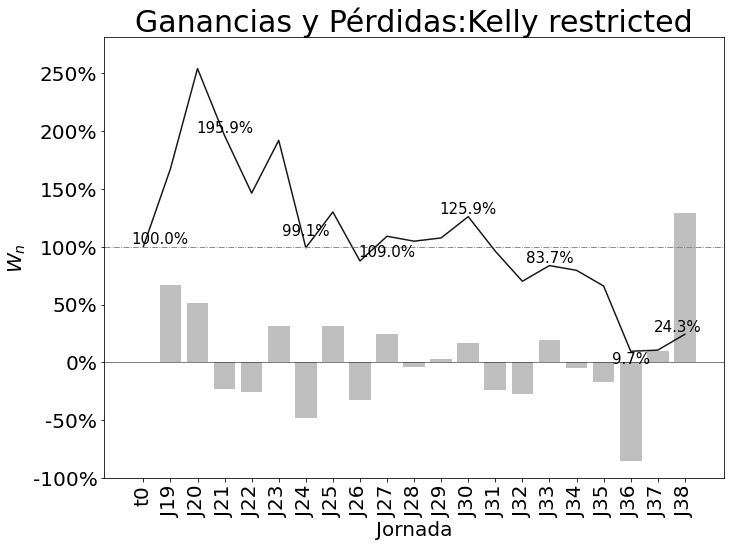

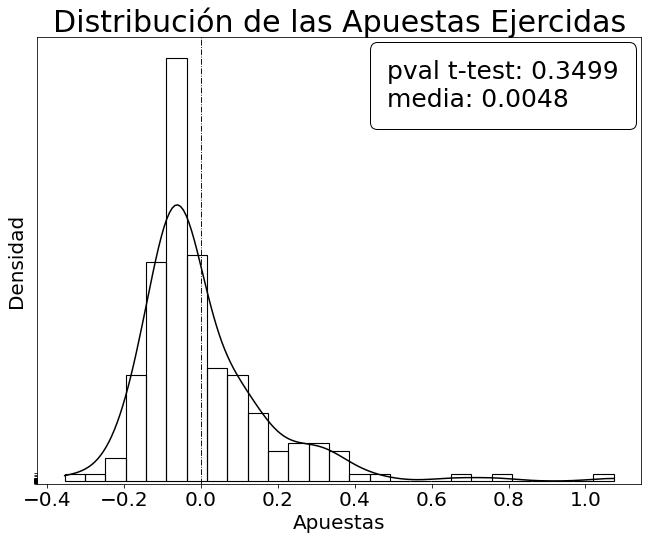

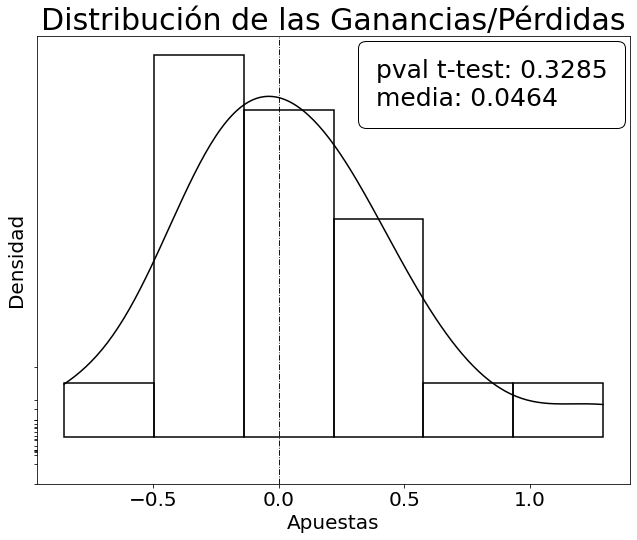

()

In [ ]:
# look performance
show_performance(
    model=kelly_restricted, 
    model_summary=eval_kelly_restricted,
    model_name='Kelly restricted'
)

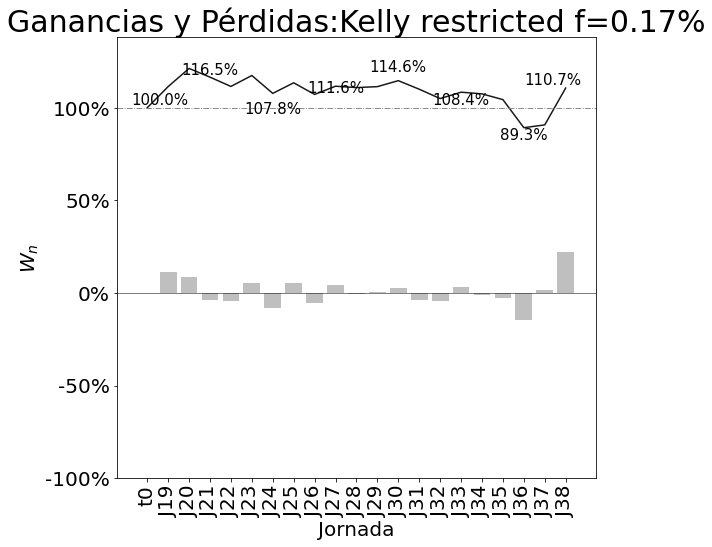

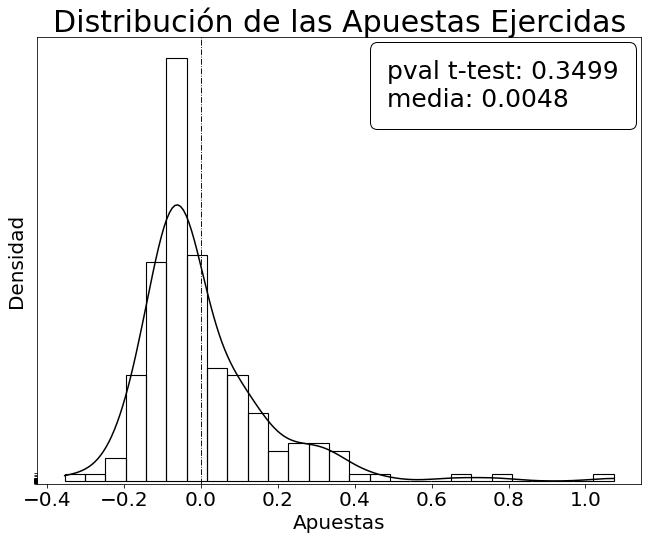

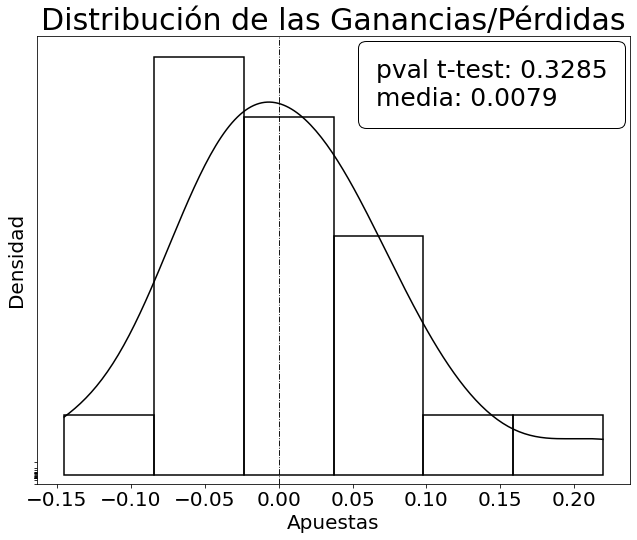

()

In [ ]:
# look performance
show_performance(
    model=kelly_restricted_fractional, 
    model_summary=eval_kelly_restricted_fract,
    model_name=f"Kelly restricted f={best_fraction}%"
)

### Bets with negative outcome

Kelly Criterion set to 0 the bets with negative expected value!


In [ ]:
# look negative expected value games outcomes in the kelly optimization
kelly_restricted['bets'][kelly_restricted['bets']['id_game'].isin(df_neg_restricted['id_game'].to_list())]


,id_game,season,matchweek,date,hometeam,awayteam,market_tracktake,result,result_categoric,odds,probas,bets
39,2430,20,22,2021-02-06,man_united,everton,0.026828,1,d,4.35,0.226345,0.0
87,2478,20,27,2021-03-06,aston_villa,wolves,0.015796,0,a,3.28,0.304076,0.0
145,2536,20,33,2021-04-25,leeds,man_united,0.024351,0,h,4.17,0.238487,0.0
159,2550,20,34,2021-05-08,sheffield_united,crystal_palace,0.016946,1,a,2.60,0.384303,0.0


## Sharpe Ratio

- Here we can found a closed form solution because $\Sigma = \text{diag}(\underline{\sigma})$, the closed solution is given by $\underline{\ell}_{*} = \Sigma^{-1}\underline{\mu}$. However, to use the optimization routine we have already developed, we optimize with the same Tutuncu's trick.


- The development of solution can be found [here](!https://quant.stackexchange.com/questions/63944/optimise-the-sharpe-ratio-of-a-portfolio-of-uncorrelated-assets).



### Optimize Restricted Sharpe Criterion: normal & fractional

Optimize Sharpe Ratio for complete stake and fractional stake.

In [ ]:
# optimization
print("--------restricted Kelly Criterion-------")
mktz_restricted = portfolios_optimization(
    tournment=dict_test_restricted,
    df=df_test_restricted,
    stake_model='markowitz',
    fractional=1
)

print("\n--------restricted Fractional Kelly Criterion-------")
mktz_restricted_fractional = portfolios_optimization(
    tournment=dict_test_restricted,
    df=df_test_restricted,
    stake_model='markowitz',
    fractional=best_fraction
)


--------restricted Kelly Criterion-------

Optimization for matchweek19

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 20.0%
                     final wealth: 65.0%                
                


Optimization for matchweek20

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 50.0%
                     final wealth: 63.0%                
                


Optimization for matchweek21

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 30.0%
                     final wealth: -14.0%                
                


Optimization for matchweek22

                     num stakes: 9 
                     wage betted: 100.0%
                     percent hitted: 22.0%
                     final wealth: -37.0%                
                


Optimization for matchweek23

                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log



                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 30.0%
                     final wealth: 45.0%                
                


Optimization for matchweek26

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 20.0%
                     final wealth: -26.0%                
                


Optimization for matchweek27

                     num stakes: 9 
                     wage betted: 100.0%
                     percent hitted: 33.0%
                     final wealth: 37.0%                
                


Optimization for matchweek28

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 50.0%
                     final wealth: 1.0%                
                


Optimization for matchweek29

                     num stakes: 10 
                     wage betted: 100.0%
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log



                     num stakes: 9 
                     wage betted: 100.0%
                     percent hitted: 33.0%
                     final wealth: 28.0%                
                


Optimization for matchweek34

                     num stakes: 9 
                     wage betted: 100.0%
                     percent hitted: 22.0%
                     final wealth: -13.0%                
                


Optimization for matchweek35

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 50.0%
                     final wealth: -8.0%                
                


Optimization for matchweek36

                     num stakes: 10 
                     wage betted: 100.0%
                     percent hitted: 0.0%
                     final wealth: -100.0%                
                


Optimization for matchweek37

                     num stakes: 10 
                     wage betted: 100.0%
             

In [ ]:
# look complete tables
mktz_restricted['metrics']


,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,markowitz,single,19,1,0.651510,1.651510e+00,10,1.0,0.275841,0.021962,0.691058,0.654366,0.896629,-inf,2,0.200000,0.731047,-0.275841
1,markowitz,single,20,1,0.633621,2.697942e+00,10,1.0,0.320884,0.016587,0.317599,0.149005,0.220111,-0.180420,5,0.500000,0.422229,-0.320884
2,markowitz,single,21,1,-0.139249,2.322256e+00,10,1.0,0.195949,0.018517,0.618296,0.369583,0.357298,0.049072,3,0.300000,0.301206,-0.195949
3,markowitz,single,22,1,-0.370736,1.461313e+00,9,1.0,0.181222,0.020812,0.377684,0.232320,0.378371,-0.647151,2,0.222222,0.297327,-0.181222
4,markowitz,single,23,1,0.430020,2.089706e+00,10,1.0,0.385074,0.018527,0.604882,0.306232,0.256306,-inf,4,0.400000,0.328807,-0.131479
5,markowitz,single,24,1,-0.323327,1.414048e+00,10,1.0,0.220674,0.020532,0.809083,0.418645,0.267735,0.156894,2,0.200000,0.193897,-0.220674
6,markowitz,single,25,1,0.447074,2.046232e+00,10,1.0,0.234366,0.020916,0.453067,0.291729,0.414603,-inf,3,0.300000,0.399493,-0.234366
7,markowitz,single,26,1,-0.256193,1.522002e+00,10,1.0,0.223823,0.019109,0.610503,0.379988,0.387405,-inf,2,0.200000,0.270826,-0.213212
8,markowitz,single,27,1,0.372915,2.089579e+00,9,1.0,0.188934,0.018381,0.675167,0.428343,0.402496,-0.215112,3,0.333333,0.410058,-0.117330
9,markowitz,single,28,1,0.010998,2.112561e+00,10,1.0,0.287507,0.014702,0.493603,0.286139,0.336047,-inf,5,0.500000,0.376634,-0.247684


In [ ]:
# look complete tables
mktz_restricted_fractional['metrics']

,model,type,matchweek,fractional,wealth,cumm_wealth,num_stakes,percent_wage,max_stake2percent_wage,charged_tt,sharpe_ratio,xreturn,volatility,log_growth,total_hits,percent_hits,best_win,worst_loss
0,markowitz,single,19,0.17,0.110757,1.110757,10,0.17,0.275841,0.003734,0.691058,0.111242,0.025913,0.095023,2,0.200000,0.124278,-0.046893
1,markowitz,single,20,0.17,0.107716,1.230403,10,0.17,0.320884,0.002820,0.317599,0.025331,0.006361,0.022006,5,0.500000,0.071779,-0.054550
2,markowitz,single,21,0.17,-0.023672,1.201276,10,0.17,0.195949,0.003148,0.618296,0.062829,0.010326,0.056395,3,0.300000,0.051205,-0.033311
3,markowitz,single,22,0.17,-0.063025,1.125566,9,0.17,0.181222,0.003538,0.377684,0.039494,0.010935,0.033691,2,0.222222,0.050546,-0.030808
4,markowitz,single,23,0.17,0.073103,1.207848,10,0.17,0.385074,0.003150,0.604882,0.052059,0.007407,0.047381,4,0.400000,0.055897,-0.022351
5,markowitz,single,24,0.17,-0.054966,1.141458,10,0.17,0.220674,0.003490,0.809083,0.071170,0.007738,0.065368,2,0.200000,0.032962,-0.037515
6,markowitz,single,25,0.17,0.076003,1.228212,10,0.17,0.234366,0.003556,0.453067,0.049594,0.011982,0.042981,3,0.300000,0.067914,-0.039842
7,markowitz,single,26,0.17,-0.043553,1.174720,10,0.17,0.223823,0.003248,0.610503,0.064598,0.011196,0.057652,2,0.200000,0.046040,-0.036246
8,markowitz,single,27,0.17,0.063396,1.249192,9,0.17,0.188934,0.003125,0.675167,0.072818,0.011632,0.065242,3,0.333333,0.069710,-0.019946
9,markowitz,single,28,0.17,0.001870,1.251527,10,0.17,0.287507,0.002499,0.493603,0.048644,0.009712,0.043070,5,0.500000,0.064028,-0.042106


### Model evaluation & Performance

In [ ]:
# evaluate restricted kelly
eval_mktz_restricted = model_summary(mktz_restricted)
eval_mktz_restricted_fract = model_summary(mktz_restricted_fractional)

# look both models
pd.DataFrame([eval_mktz_restricted, eval_mktz_restricted_fract])


,model,final_wealth,total_bets,mean_num_bets_per_matchweek,mean_wage_bet_per_matchweek,total_hits,mean_sharpe,mean_log_growth,mean_volatility,pval_bets,pval_wealth
0,markowitz_single_1,3.181694e-16,176,9.777778,1.00,0.323864,0.615496,-inf,0.376019,0.349243,0.307019
1,markowitz_single_0.17,1.348703e+00,196,9.800000,0.17,0.331633,0.621988,0.058396,0.011528,0.208512,0.157196


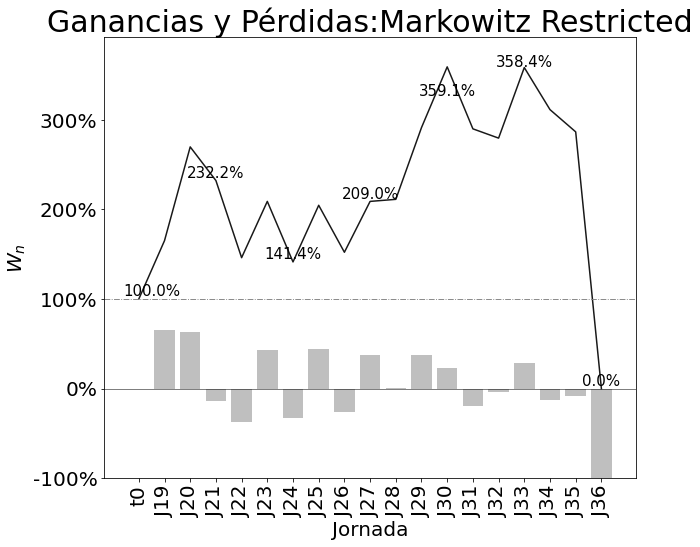

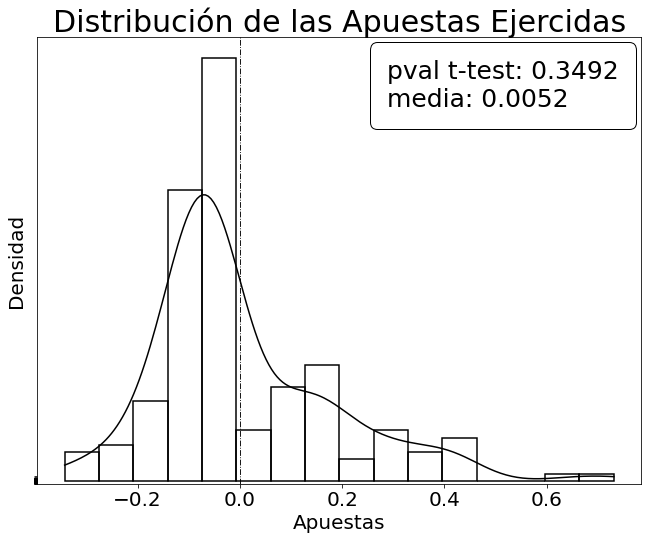

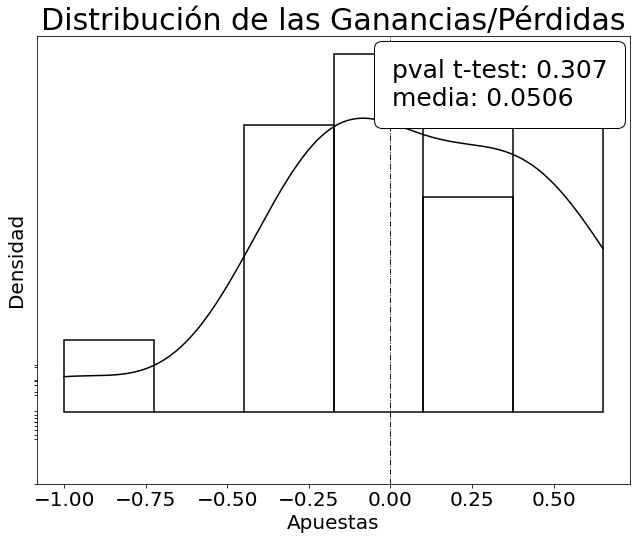

()

In [ ]:
# look performance
show_performance(
    model=mktz_restricted, 
    model_summary=eval_mktz_restricted,
    model_name='Markowitz Restricted'
)

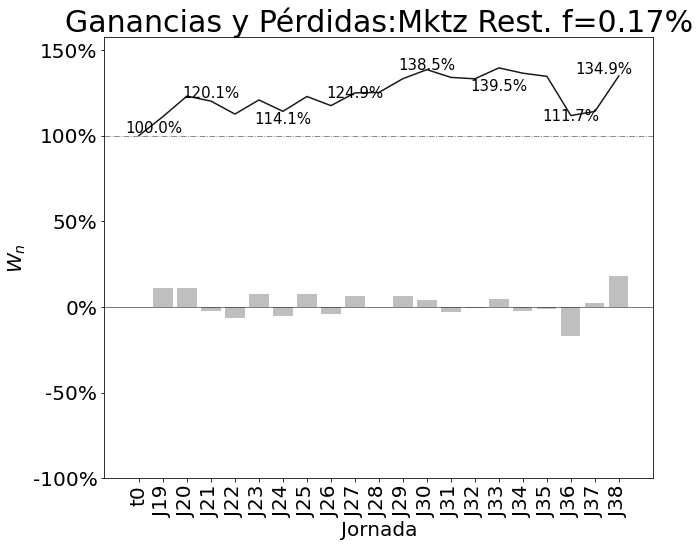

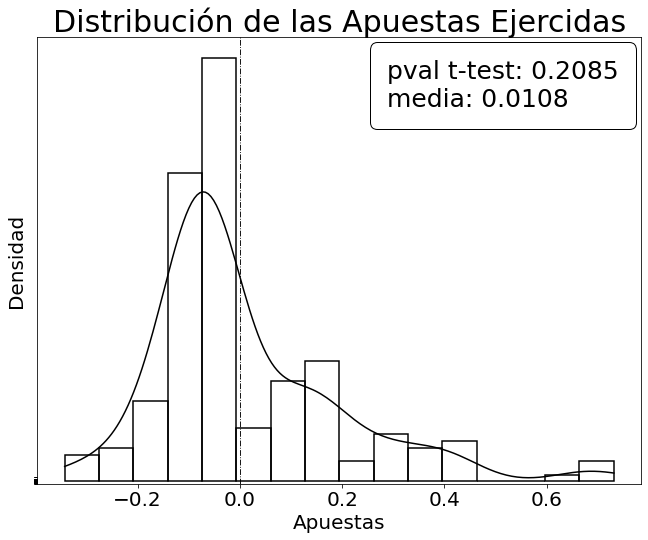

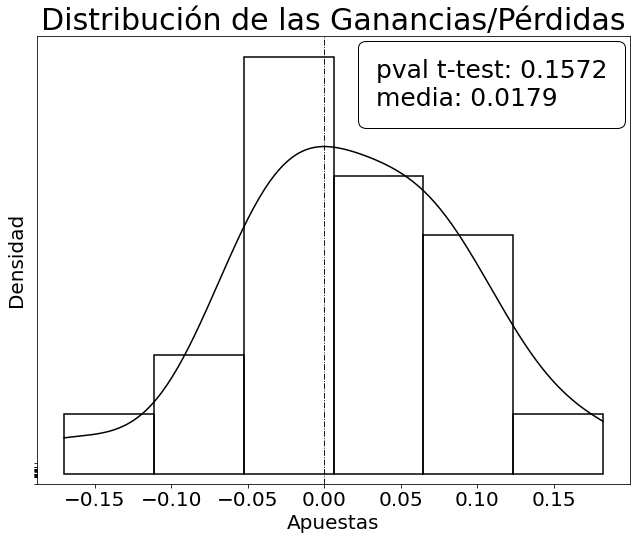

()

In [ ]:
# look performance
show_performance(
    model=mktz_restricted_fractional,   
    model_summary=eval_mktz_restricted_fract,
    model_name=f"Mktz Rest. f={best_fraction}%"
)

### Bets with negative outcome

Markowitz set to 0 the bets with negative expected value!


In [ ]:
# look negative expected value games outcomes in the markowitz optimization
mktz_restricted['bets'][mktz_restricted['bets']['id_game'].isin(df_neg_restricted['id_game'].to_list())]


,id_game,season,matchweek,date,hometeam,awayteam,market_tracktake,result,result_categoric,odds,probas,bets
39,2430,20,22,2021-02-06,man_united,everton,0.026828,1,d,4.35,0.226345,0.0
87,2478,20,27,2021-03-06,aston_villa,wolves,0.015796,0,a,3.28,0.304076,0.0
145,2536,20,33,2021-04-25,leeds,man_united,0.024351,0,h,4.17,0.238487,0.0
159,2550,20,34,2021-05-08,sheffield_united,crystal_palace,0.016946,1,a,2.60,0.384303,0.0


# Comparative of Models

- Here we compare the general metrics by model, as well the individual bets and how much does them differ.

- Also we make emphasis in certain aspects of the models.

## Table of aggregated metrics per model

Here we conclude that Fractional Restricted Markowitz is the best stake model. 

In [ ]:
# get values
list_model_metrics = [
  # kelly's models
  eval_kelly_general, eval_kelly_general_fract, 
  eval_kelly_restricted, eval_kelly_restricted_fract,

  # markowitz' models
  eval_mktz_general, eval_mktz_general_fract, 
  eval_mktz_restricted, eval_mktz_restricted_fract,
]

# look table
df_model_metrics = (
    # instantiate
    pd.DataFrame(
      data=list_model_metrics,
      columns=list(list_model_metrics[0])    
    )
    # arrange
    .sort_values('final_wealth', ascending=False)
)

df_model_metrics

,model,final_wealth,total_bets,mean_num_bets_per_matchweek,mean_wage_bet_per_matchweek,total_hits,mean_sharpe,mean_log_growth,mean_volatility,pval_bets,pval_wealth
7,markowitz_single_0.17,1.348703e+00,196,9.800000,0.170000,0.331633,0.621988,0.058396,0.011528,0.208512,0.157196
3,kelly_single_0.17,1.106666e+00,195,9.750000,0.140558,0.333333,0.580924,0.064143,0.016229,0.349873,0.328538
1,kelly_multiple_0.17,1.020087e+00,319,15.950000,0.166281,0.304075,0.642523,0.070269,0.015619,0.424446,0.411158
5,markowitz_multiple_0.17,9.663429e-01,323,16.150000,0.169995,0.303406,1.406034,0.039180,0.003835,0.501309,0.502026
2,kelly_single_1,2.431725e-01,195,9.750000,0.826814,0.333333,0.580924,0.206945,0.561566,0.349873,0.328538
4,markowitz_multiple_1,1.610958e-01,323,16.150000,0.999970,0.303406,1.406034,0.164280,0.132694,0.501309,0.502026
0,kelly_multiple_1,3.164211e-02,319,15.950000,0.978123,0.304075,0.642523,0.234772,0.540464,0.424446,0.411158
6,markowitz_single_1,3.181694e-16,176,9.777778,1.000000,0.323864,0.615496,-inf,0.376019,0.349243,0.307019


## Compare bets per model type (markowitz vs kelly)

In [ ]:
# comparative table of matchweek 38 (profitable matchweek)
df_bets_compare_mw38 = (
    # subset kelly stakes
    kelly_restricted['bets']
      .query("matchweek == 38")
      .rename(columns={'bets': 'kelly'})
      [["id_game", "hometeam", "awayteam", "odds", "probas", "result_categoric", "kelly"]]
    # left join with markowitz 
    .merge(
        right=(
            mktz_restricted['bets']
            .query("matchweek == 38")
            .rename(columns={'bets': 'markowitz'})
            [["id_game", "result_categoric", "markowitz"]]
      ),
        how='left',
        on=['id_game', "result_categoric"]
    )
    # get game name
    .assign(
        # name_game = lambda x: x['hometeam'] + ' - ' + x['awayteam'],
        expected_profit = lambda x: x["probas"] * x["odds"] - 1
        )

    # select important columns
    [['hometeam', 'awayteam', 'result_categoric', 
      "odds", "probas", 'expected_profit', 'kelly', 'markowitz']]

    # hierarchical index
    # .set_index(['hometeam', 'awayteam', 'result_categoric', 'probas', 
    #             'odds', 'expected_profit'])

    # transpose
    .transpose()
)

# look 
df_bets_compare_mw38



,0,1,2,3,4,5,6,7,8,9
hometeam,arsenal,aston_villa,fulham,leeds,leicester,liverpool,man_city,sheffield_united,west_ham,wolves
awayteam,brighton,chelsea,newcastle,west_brom,tottenham,crystal_palace,everton,burnley,southampton,man_united
result_categoric,d,h,a,a,a,a,h,a,a,a
odds,4.46,7,3.41,7,3.5,18.32,1.47,2.45,5.03,2.75
probas,0.262493,0.316639,0.414808,0.268504,0.315811,0.101661,0.753885,0.48461,0.251111,0.4188
expected_profit,0.170719,1.21647,0.414496,0.879529,0.10534,0.862422,0.10821,0.187294,0.263088,0.1517
kelly,0.0322925,0.178947,0.127699,0.120484,0.0265489,0.0393491,0.143282,0.0855588,0.044681,0.0560753
markowitz,0.0444326,0.114991,0.147176,0.0915931,0.0398865,0.0281999,0.270497,0.125209,0.0554184,0.0825962


In [ ]:
# comparative table of matchweek 34 (arbitrage game)
df_bets_compare_mw34 = (
    # subset kelly stakes
    kelly_general['bets']
      .query("id_game == 2543")
      .rename(columns={'bets': 'kelly'})
    # left join with markowitz 
    .merge(
        right=(
            mktz_general['bets']
            .query("id_game == 2543")
            .rename(columns={'bets': 'markowitz'})
            [["id_game", "result_categoric", "markowitz"]]
      ),
        how='left',
        on=['id_game', "result_categoric"]
    )
    # get "probabilities" of the market
    .assign(
        inverse_odd = lambda x: 1/x['odds'],
        name_game = lambda x: x['hometeam'] + ' - ' + x['awayteam']
    )

    # select important columns
    [['name_game', 'result_categoric', 'market_tracktake', 'probas', 'odds', 'inverse_odd', 'kelly', 'markowitz']]

)

# look 
df_bets_compare_mw34

,name_game,result_categoric,market_tracktake,probas,odds,inverse_odd,kelly,markowitz
0,everton - aston_villa,h,-0.008543,0.423351,2.07,0.483092,0.005167,0.487144
1,everton - aston_villa,d,-0.008543,0.320805,3.70,0.270270,0.073483,0.272538
2,everton - aston_villa,a,-0.008543,0.255844,4.20,0.238095,0.040441,0.240093


In [ ]:
# save bets prediction 
# generate model folder
folder_results = "Results/Predictions"
name_file_model = folder_results + "/bets_mktz_restricted_fract17.csv"
if not os.path.exists(folder_results):
  os.makedirs(folder_results)

mktz_restricted_fractional['bets'].to_csv(name_file_model)

# Skill v.s. Luck

- To have a benchmark, more than a simple t-test, we simulate a fractional bet strategy with a dirichlet distribution with concentration parameters $\alpha_{i} = 1, \quad \forall i = 1, 2, ..., M$. Then we calculate the times the final wealth best model is above the final wealth of each simulated strategy and we interpret this as the probability of being skilled.

- We also simulate strategies for distinct values of $\alpha_{i} = K_{\alpha}$ and different fractional bets to understand which type of a prior strategy can minimize the losses.

## Simulation of bets: Monkeys vs Model

Is remarkable to understand that simulated strategies ($\alpha_i = 1$ and fractional) without knowledge of the odds, probabilities and history of the teams can overcome the best model founded more than half of the times.

This is hint that maybe we can be fooled by randomness, and that the assumption that we have estimated the real probabilities is not true.

In [ ]:
# simulation of _restricted_ bets
bets_sim = bets_simulation(
    tournment=dict_test,
    n_sim=500, 
    kforce=1,
    fractional=best_fraction,
    seed=10
)


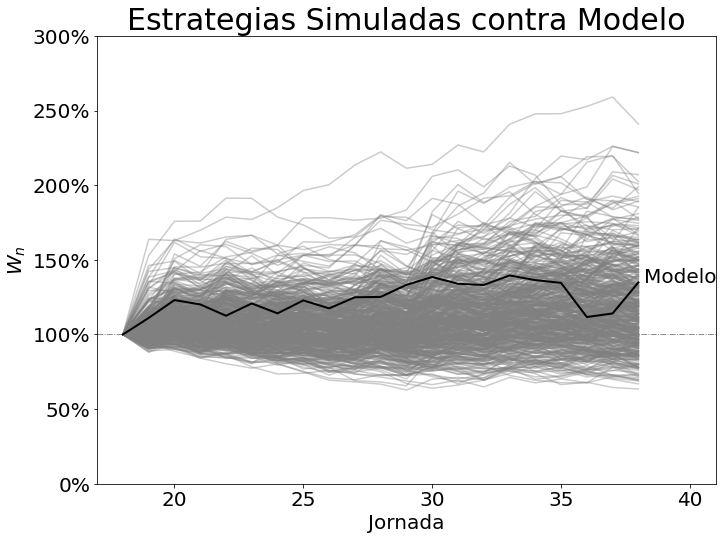

()

In [ ]:
# plot simulation vs model
plt_sim_vs_model(
    df_bets=bets_sim,
    strategy_metrics=mktz_restricted_fractional['metrics']
)


In [ ]:
# probability of being skilled 
# get final wealth of bets
last_wn_sims = bets_sim.groupby('num_sim')['cumm_wealth'].tail(1).to_numpy()

# compute proba
wn_best_model = mktz_restricted_fractional['metrics']['cumm_wealth'].tail(1).squeeze()
proba_skilled = np.mean(last_wn_sims < wn_best_model)

print(f"The proportion of simulations with final less wealth than model were {100 * proba_skilled}%")

The proportion of simulations with final less wealth than model were 77.8%


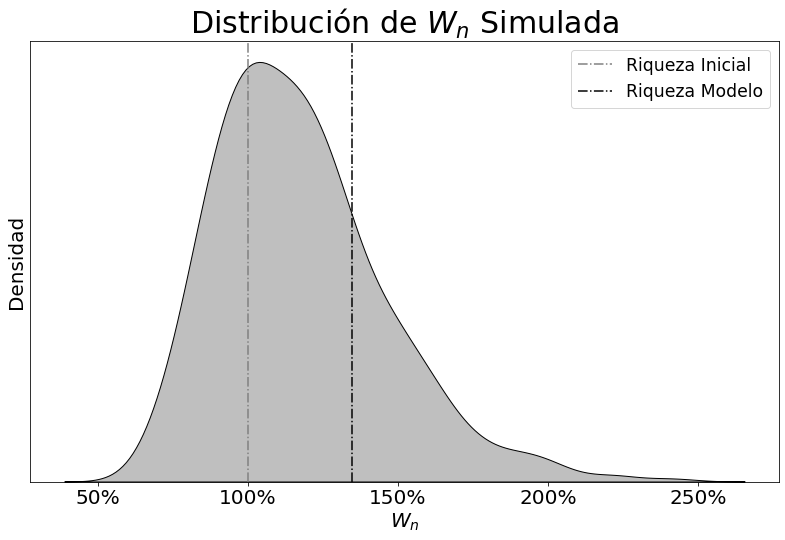

In [ ]:
# plot
fig, ax = plt.subplots()

# plot distribution of final wealth of the simulated bet strategies
sns.kdeplot(last_wn_sims, fill=True, color='black')

# show thresholds
ax.axvline(x=1, color='gray', linestyle='-.', label='Riqueza Inicial')
ax.axvline(x=wn_best_model, color='black', linestyle='-.', label='Riqueza Modelo')

# generate label
ax.legend(loc='upper right', fontsize='xx-large')


#  preatty graph
plt.ylabel('Densidad', fontsize=20)
plt.xlabel('$W_{n}$', fontsize=20)
plt.title('Distribución de $W_{n}$ Simulada', fontsize=30)

ax.set_yticks([])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])
ax.tick_params(axis='both', which='major', labelsize=20)

# save plot #
# generate figure folder
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate sub folder
final_folder = "Figures_Colab/FinancialModel/"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
plt.savefig(final_folder + "dist_wn_sim.png", bbox_inches='tight')   

plt.show()


## Simulation of fractional and diversification strategies

Simulation with _all_ games and _all_ outcomes for distinct diversification strategies $\alpha_{i} = K_{\alpha}$ and different fractional bets. 

- A conclusion is that diversification is power.

- Another, save money for maximize compounded wealth.

In [ ]:
# generate grid
N = 20
fract = np.linspace(0.01, 1, N)
k_alpha = np.power(10, np.linspace(-3, 1.5, N))

x, y = np.meshgrid(fract, k_alpha)
Mmedian = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Mmedian[i, j] = median_simulation_wealth(
            fractional=x[i, j],
            kforce=y[i, j],
            tournment=dict_test,
            n_sim=200,
            seed=10            
            )



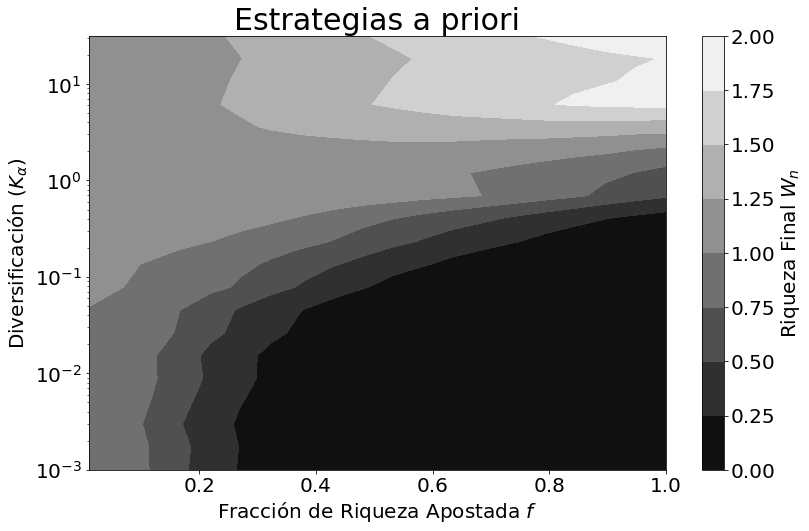

In [ ]:
# plot strategy
fig, ax = plt.subplots()
cf = ax.contourf(x, y, Mmedian, cmap='gray')

# add color bar
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label("Riqueza Final $W_{n}$", size=20)
cbar.ax.tick_params(labelsize=20)

# pretty graph
ax.set_yscale('log')
plt.ylabel('Diversificación ($K_{\\alpha}$)', fontsize=20)
plt.xlabel('Fracción de Riqueza Apostada $f$', fontsize=20)
plt.title('Estrategias a priori', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

# save plot #
# generate figure folder
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate sub folder
final_folder = "Figures_Colab/FinancialModel/"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
plt.savefig(final_folder + "apriori_sim_strategies.png", bbox_inches='tight')   

plt.show()

## Metrics Analysis

The main hypothesis is that _the real probabilities_ of the outcomes _are known_ so the Kelly Criterion can work. But, the models sawn say the opposite. 

With simulations and simple regression analysis the hypothesis of _known probabilities_ will be tested.


In [ ]:
# get final wealth per 
bets_sim_smmry =(
    bets_sim
    .groupby('num_sim', as_index=False)
    .agg({'cumm_wealth': lambda x: np.log(x.tail(1)), 'log_growth': 'mean'})
)

# standarize data
bets_sim_smmry[['cumm_wealth', 'log_growth']] = StandardScaler().\
    fit_transform(bets_sim_smmry[['cumm_wealth', 'log_growth']])

# lm analysis
X = sm.add_constant(bets_sim_smmry['log_growth'])
Y = bets_sim_smmry['cumm_wealth']
lm = sm.OLS(Y, X)
lm = lm.fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:            cumm_wealth   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2833
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.595
Time:                        02:12:24   Log-Likelihood:                -709.33
No. Observations:                 500   AIC:                             1423.
Df Residuals:                     498   BIC:                             1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.469e-17      0.045   7.74e-16      1.0

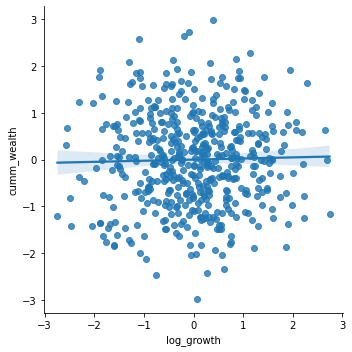

In [ ]:
# plot scatter & lm fit
sns.lmplot(x='log_growth', y='cumm_wealth', data=bets_sim_smmry, palette='b')





# Save

In [ ]:
# mount personal google drive to create and save cache & figures
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/cache_tesis/'

# !pip install cache-magic
# import cache_magic
# !mkdir .cache
# !ln -s '/content/drive/MyDrive/cache_tesis/' /content/.cache

Mounted at /content/drive
/content/drive/MyDrive/cache_tesis


In [ ]:
# copy Figures_Colab and ALL the files in it to our google drive
# %mkdir "/content/drive/MyDrive/cache_tesis/figures" # create folder
%cp -R "/content/cloned-repo/Figures_Colab" "/content/drive/MyDrive/cache_tesis/figures" # save images
%cp -R "/content/cloned-repo/Results" "/content/drive/MyDrive/cache_tesis/results" # save files